<a href="https://colab.research.google.com/github/cffan/interspeech_iBCI_tutorial/blob/main/interspeech2024_bci_neural_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telluride - Phonemes 2025
# Stephanie Haro - Brown University
# July 2, 2025

(spawned off my Interspeech 2024 tutorial) https://github.com/cffan/interspeech_iBCI_tutorial/blob/main/interspeech2024_bci_neural_tuning.ipynb

---

Copyright 2025, Brown University, Providence, RI.

All Rights Reserved

Permission to use, copy, modify, and distribute this software and
its documentation for any purpose other than its incorporation into a
commercial product or service is hereby granted without fee, provided
that the above copyright notice appear in all copies and that both
that copyright notice and this permission notice appear in supporting
documentation, and that the name of Brown University not be used in
advertising or publicity pertaining to distribution of the software
without specific, written prior permission.

BROWN UNIVERSITY DISCLAIMS ALL WARRANTIES WITH REGARD TO THIS SOFTWARE,
INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY
PARTICULAR PURPOSE.  IN NO EVENT SHALL BROWN UNIVERSITY BE LIABLE FOR
ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.


# Starter Code Objectives

* Load tuning data (simple isolated task data NOT continuous sentence data) from [Willet 2023 Dryad data set](https://datadryad.org/stash/dataset/doi:10.5061/dryad.x69p8czpq).
* Select feature set from the file and pre-process 
* Run standard Gaussian Naive Bayes (GNB) phoneme classifier that operates on mean activity along a window
* Run PCA on neural features


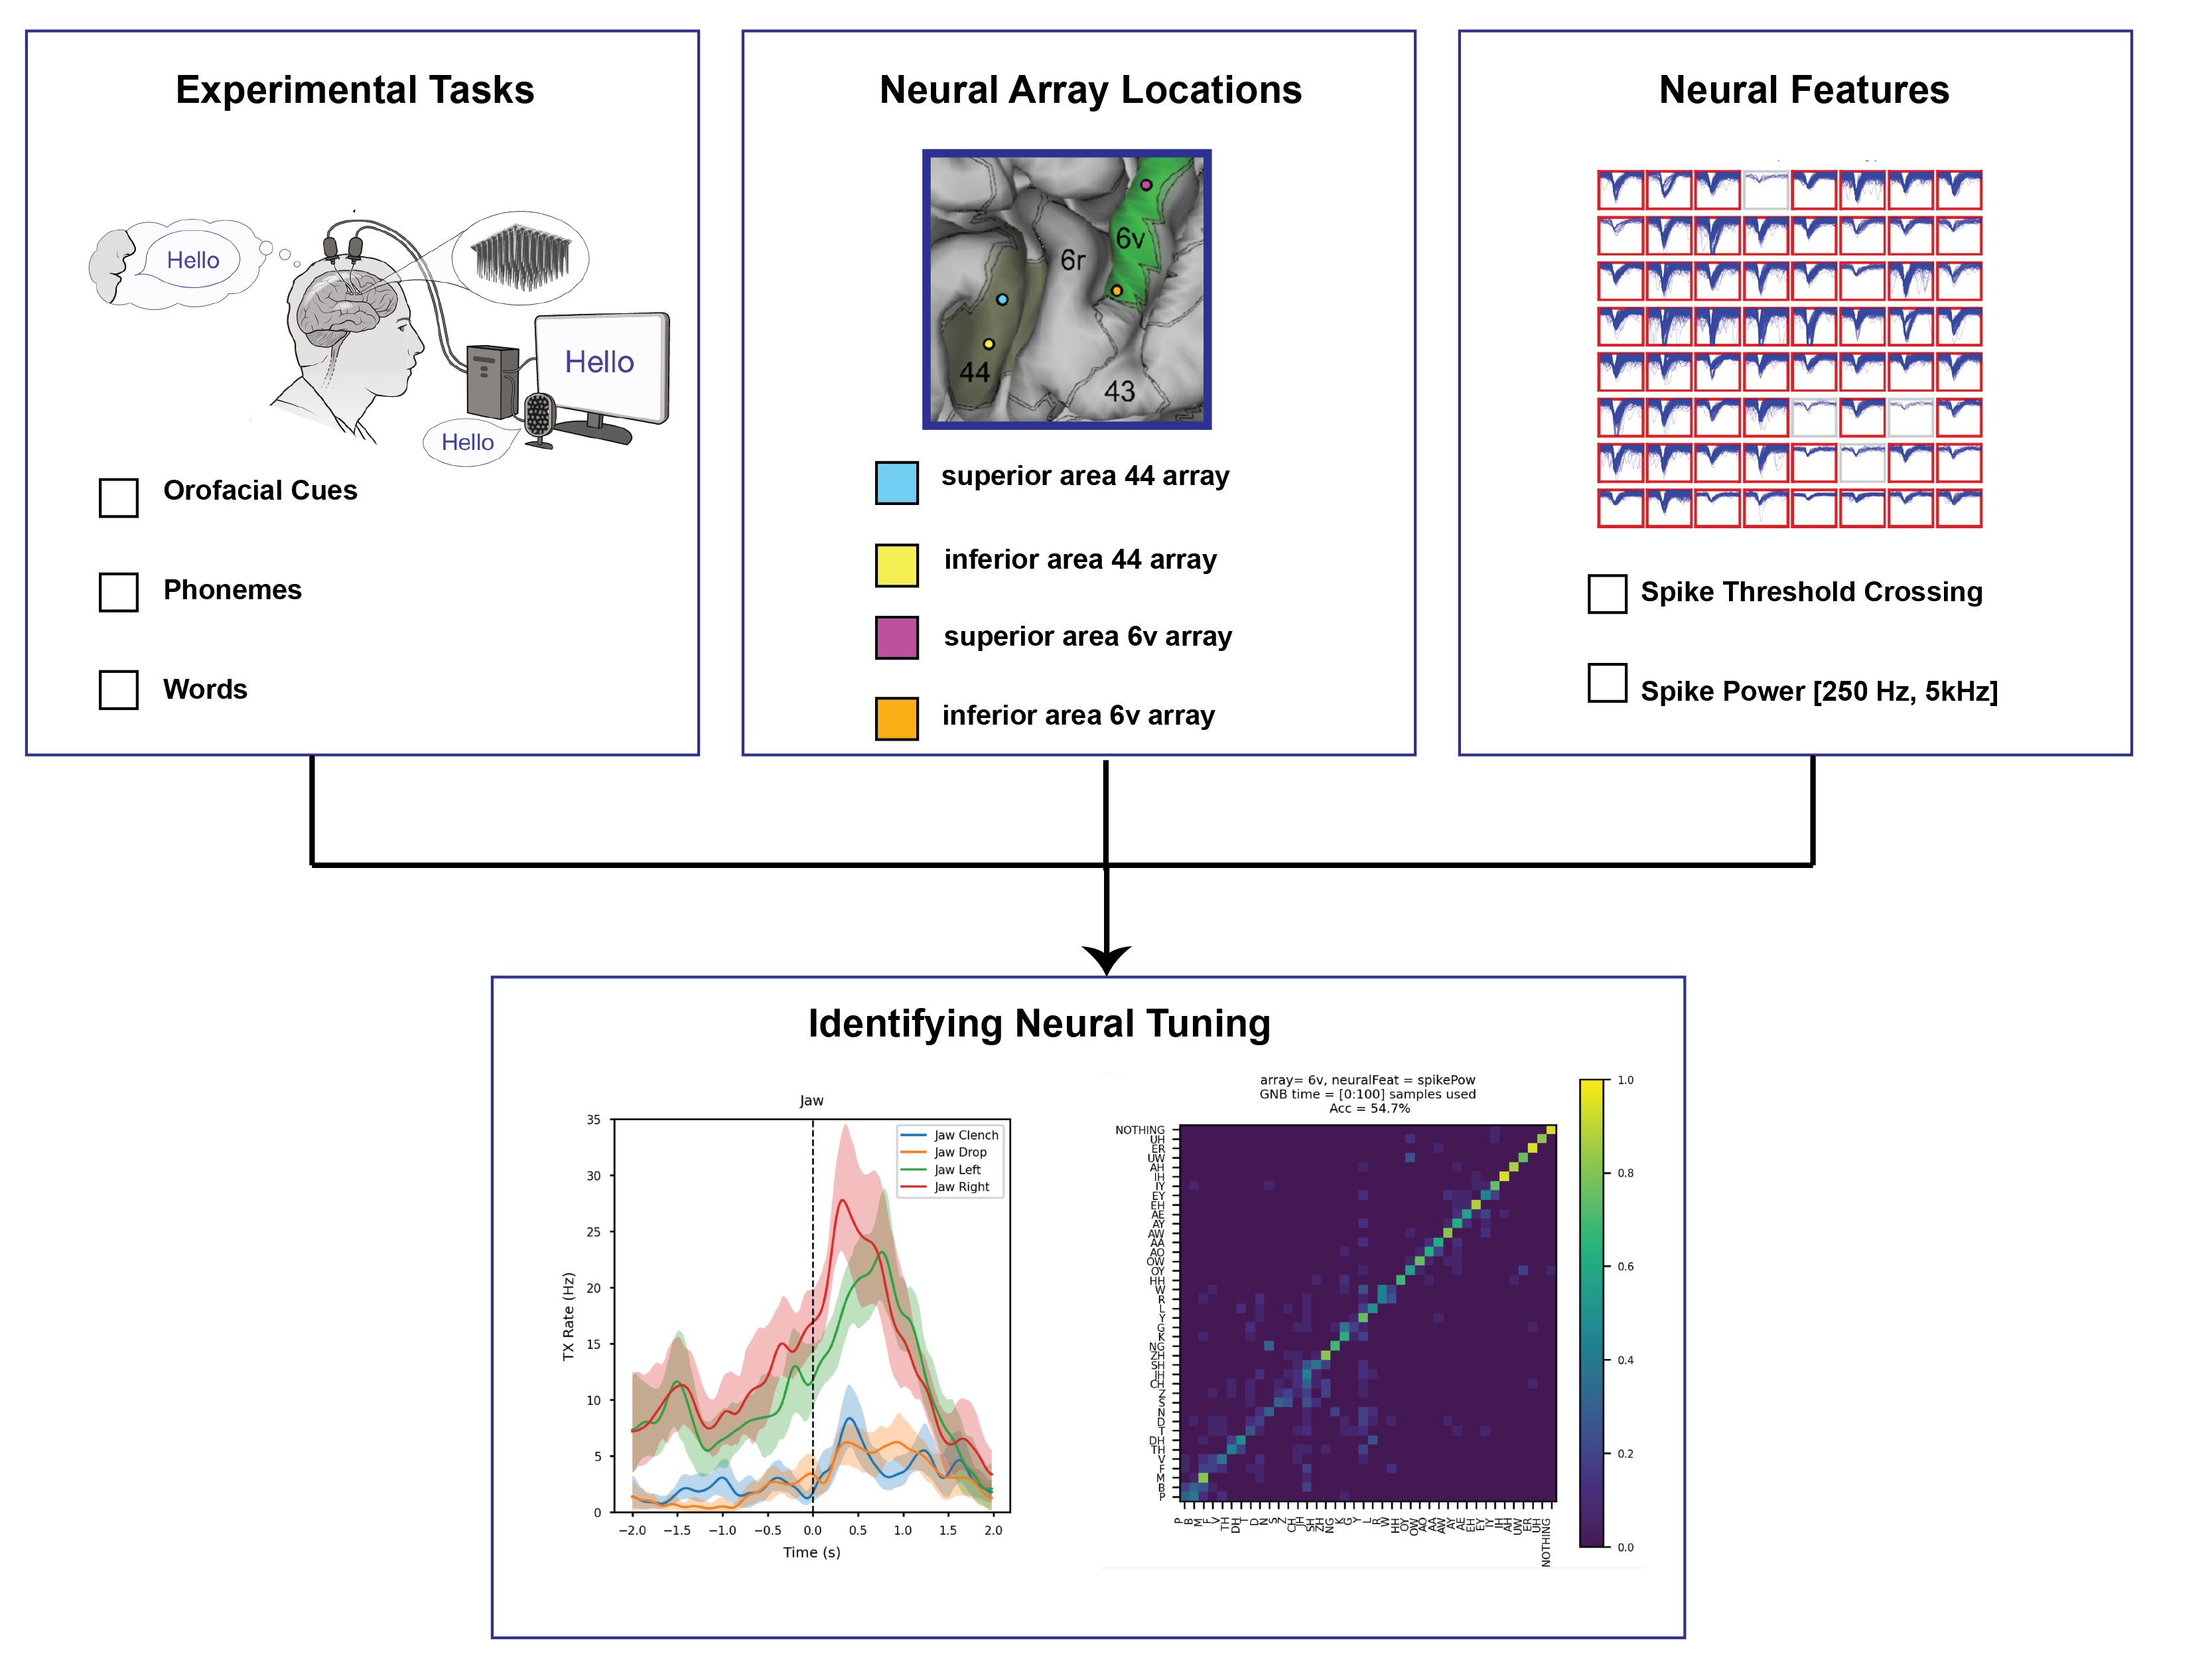

# Notebook Set Up

In [1]:
import os
import sys
from pathlib import Path
import time
import numpy as np
import scipy
import scipy.io
from scipy.io import savemat
import scipy.stats as stats

from sklearn.metrics import f1_score
from scipy.ndimage import gaussian_filter1d
from numba import njit

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import cm
import matplotlib.pyplot as pyplt
import pandas as pd
import matplotlib.patches as mpatches


from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from sklearn.naive_bayes import GaussianNB

import numpy as np
import jax
import jax.numpy as jnp
import jax, jax.numpy as jnp
from flax import linen as nn
import optax, functools, itertools, time, tqdm

from jax import grad, jit, random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
from jax import vmap
from sklearn.model_selection import KFold

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import jax
from jax import jit, grad, random
import numpy as np

import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import random
random.seed(20240430)
print('Set Fixed Seed')
print(random.random())

Set Fixed Seed
0.012781644185369756


# Define BaseDir

In [2]:
baseDir = '/Users/sharo/Documents/Data/External/T12/version_20230901/' # your basedir that holds TUningTasks folder 

# Explanation of Experimental Tasks

**Participant Information**

This data set consists of neural data collected from BrainGate clinical trial participant T12. They have bulbar-onset amyotrophic lateral sclerosis (ALS) which impacts their ablity to actuate movement associated with speech. Concretely, at the time of this collection, they retained some visible orofacial muscle movement and were able to vocalize (volitionally exhale and utter sound). However, their speech is dysarthric and considered unitelligible.  


---

**Experimental Tasks:**


The data set consists of data collected when T12 attempted to perform one of the three following tasks:




**Phoneme Sweep Task**

In phoneme sweep experiment, the participant was tasked with producing phonemes in isolation. Here is the phoneme set transcribed using [ARPABET](https://en.wikipedia.org/wiki/ARPABET) notation. Consonants were paired with a vowel since some consonants can not be produced in isolation. All consonants were cued using a paired vowel of AA (e.g. 'B AA'). Vowels were cued by embedding the vowel in a cue word, where the target phoneme to produce in isolation was marked using capitalization (e.g. 'gOOse'). Below is the phoneme set used in the phoneme sweep experiment consisting of 39 phonemes and a silence cue. There are two phoneme sweep sessions, t12.2024.04.21 has 16 repetitions of each phoneme sweep cue, while t12.2024.04.21 has 20 repetitions.

{'B','CH','NOTHING','D','F','G','HH','JH','K','L','ER','M','N','NG','P','R','S','SH','DH','T','TH', 'V','W','Y','Z','ZH','OY','EH','EY','UH','IY','OW','UW','IH','AA','AW','AY','AH','AO','AE'}


---


**Orofacial Sweep Task**

In the orofacial sweep experiment, the participant was tasked with attempting to produce the following set of 33 orofacial movements in isolation, in addition to a "do nothing" cue. For a given trial, text instructions on the screen indicated the movement. At the end of the trial, the participant returned to a neutral orofacial posture. There are 20 repetitions of each cue in the orofacial sweep set.

{'CHEEKS - Puff Left',	'CHEEKS - Puff Right',	'CHEEKS - Puff Up',	'CHEEKS - Suck in',	'Do Nothing',	'EYEBROWS - Furrow (Wrinkle Forehead)',	'EYEBROWS - Raise',	'EYEBROWS - Raise Left Only',	'EYEBROWS - Raise Right Only',	'EYES - Close Tightly',	'EYES - Open Wide',	'EYES - Wink Left',	'EYES - Wink Right',	'JAW - Clench tightly',	'JAW - Drop down',	'JAW - Move Backward',	'JAW - Move Forward',	'JAW - Move Left',	'JAW - Move Right',	'LARYNX - Hum high',	'LARYNX - Hum loud',	'LARYNX - Hum low',	'LARYNX - Hum soft',	'LIPS - Frown',	'LIPS - Pucker',	'LIPS - Pucker Left',	'LIPS - Pucker Right',	'LIPS - Smile',	'LIPS - Tuck as if blotting',	'TONGUE - Back of Lower Teeth',	'TONGUE - Back of Upper Teeth',	'TONGUE - Left Cheek',	'TONGUE - Right Cheek',	'TONGUE - Roof Of Mouth'}


---

**Word Sweep Task**

In the word sweep experiment, the participant was tasked with attempting to produce the following set of 50 words in isolation, in addition to a silence cue. There are 20 repetitions of each cue in the word sweep set.

{'DO NOTHING',	'am',	'are',	'bad',	'bring',	'clean',	'closer',	'comfortable',	'coming',	'computer',	'do',	'faith',	'family',	'feel',	'glasses',	'going',	'good',	'goodbye',	'have',	'hello',	'help',	'here',	'hope',	'how',	'hungry',	'i',	'is',	'it',	'like',	'music',	'my',	'need',	'no',	'not',	'nurse',	'okay',	'outside',	'please',	'right',	'success',	'tell',	'that',	'they',	'thirsty',	'tired',	'up',	'very',	'what',	'where',	'yes',	'you'}

---


**Experimental Paradigm**

Each of the tasks were implemented using an instructed delay format. At the onset of a trial, the instruction period consisted of a red square with instructional text and the "go" period consisted of the time when the square turned green and the participan was tasked with attempting the task.



**Later on there is a code cell where you can select your desired experimental task:**



*  phoneme sweep
*  orofacial sweep
*  word sweep




# Neural Array Locations


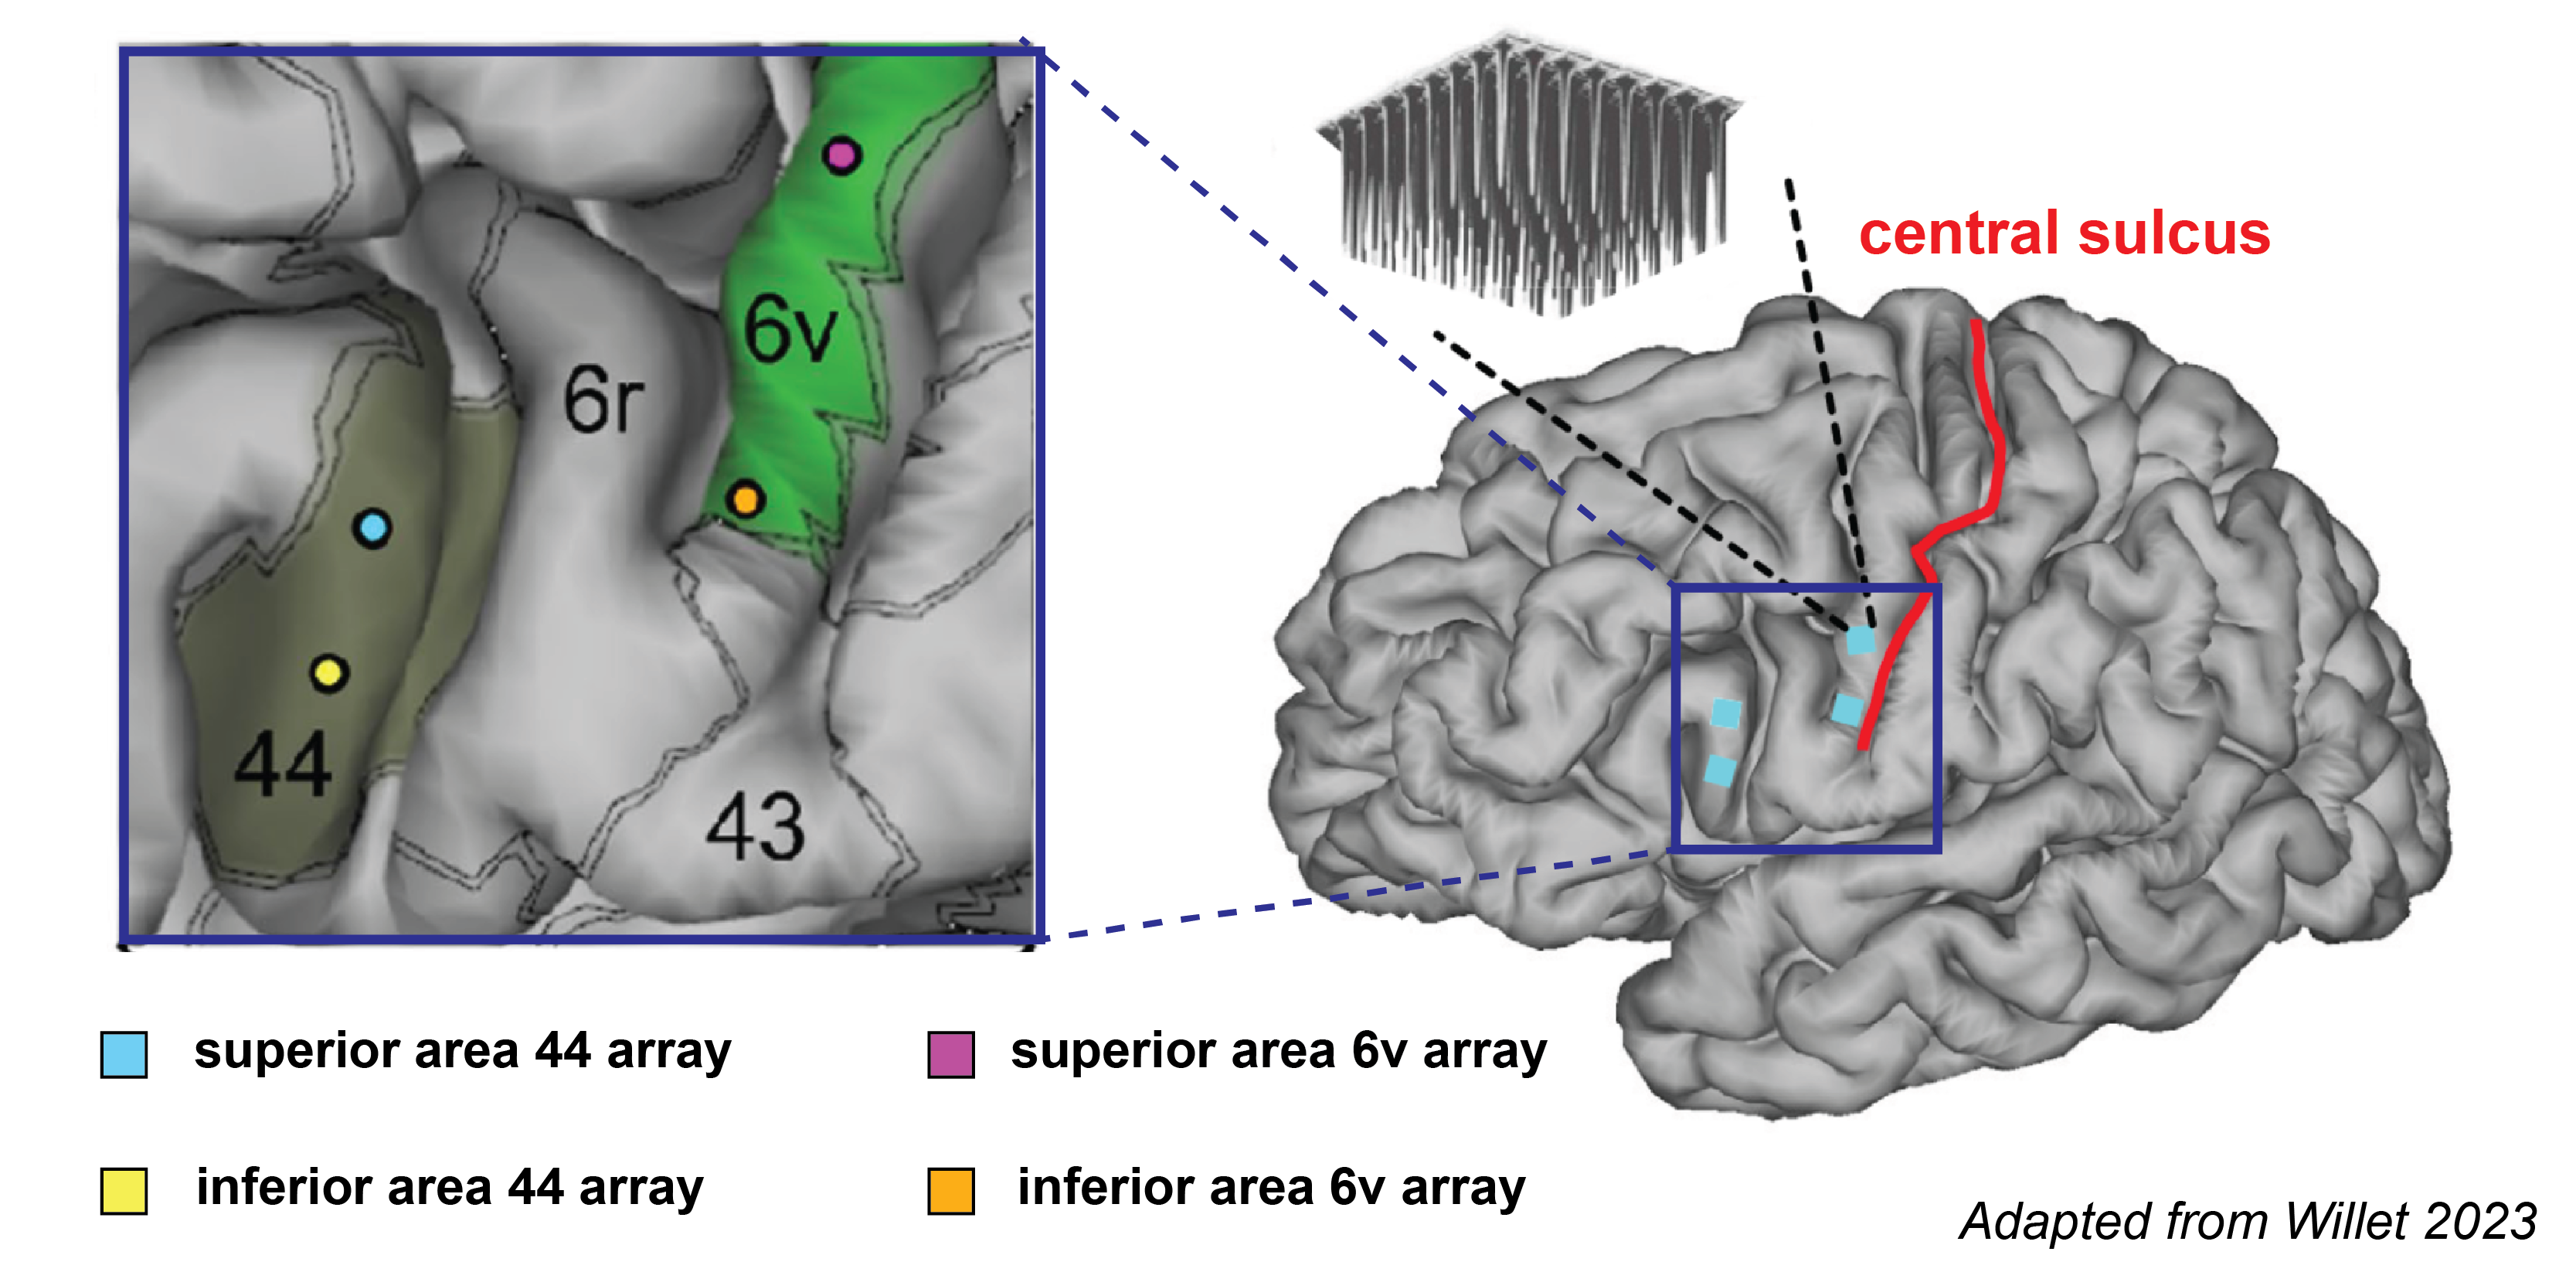

**Area 6v**

Area 6v was found to contain rich articulator representation (Willet 2023).


**Area 44**

Area 44 was found to contain little to no articulator, orofacial placement information (Willet 2023).

**Later on there is a code cell where you can select to use your desired neural feature:**


*   brainArea2use = '6v_and_44'
*   brainArea2use = '6v'
*   brainArea2use = 'd6v_superior'
*   brainArea2use = 'v6v_inferior'
*   brainArea2use = '44'
*   brainArea2use = '44_superior'
*   brainArea2use = '44_inferior'





# Neural Features

**The data set contains the following neural features:**
Feature descriptions, along with channel mapping can be downloaded directly from the Dryad data set file entitled 'tuningTasks_readme.txt' which can be directly downloaded [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.x69p8czpq#:~:text=14.80%20GB-,tuningTasks...readme.txt,-6.51%20KB)

*   'spikePow' = "spikePow : T x F matrix of binned spike band power (20 ms bins), where T = number of time steps in the experiment and F = number of channels (256). Spike band power was defined as the mean of the squared voltages observed on the channel after high-pass filtering (250 Hz cutoff; units of microvolts squared). The data was denoised with a linear regression reference technique."

*   tx1 : "T x F matrix of binned threshold crossing counts (20 ms bins), where T = number of time steps in the experiment and F = number of channels (256). The data was denoised with a linear regression reference technique and a -3.5 x RMS threshold was used. The channels correspond to the arrays in the same way as spikePow described above."

*  tx2 : Same as tx1 but with a -4.5 x RMS threshold.

*  tx3 : Same as tx1 but with a -5.5 x RMS threshold.

*  tx4 : Same as tx1 but with a -6.5 x RMS threshold.





**Later on there is a code cell where you can select to use your desired neural feature:**


*   neuralFeature2use = 'spikePow' # spike power
*   neuralFeature2use = 'binnedTX' # neural threshold crossings
*   neuralFeature2use = 'spikePow_and_binnedTX' # both spike power and neural threshold crossings




**Select your own combination of neural features:**

If you would like to use a different spike threshold crossing or a combination of spike threshold crossing neural features, modify the gatherData() function such that the set you desire is set to data['feat'].

# Load in the Data Sets

Please download these two elements from the Dryad website

* tuningTasks_readme.txt 6.51 KB 
* tuningTasks.tar.gz 941.34 MB 


In [3]:

phonemesDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.26_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'tuningTasks/t12.2022.05.03_fiftyWordSet.mat')


# Set up Analysis Experiment

** Run GNB classficiation on phonemes**
* task2use = 'phoneme'
* brainArea2use = '6v'
* neuralFeature2use = binnedTX #'spikePow'
* subtractMeansWithinBlock = True # use for GNB classification
* timeRange2LoadInBounds = [-50,50] # use for GNB classification, corresponds to [-1,1] SECONDS ABOUT GO CUE

**Select Experimental Task to Use**

In [4]:
### Select Experimental Task to Use
## uncomment one of these at a time

task2use = 'phoneme'
# task2use = 'orofacial'
# task2use = 'words'

if task2use == 'phoneme':
  tickLabels = ['B','CH','NOTHING','D','F','G','HH','JH',
                  'K','L','ER','M','N','NG','P','R','S','SH',
                  'DH','T','TH', 'V','W','Y','Z','ZH','OY',
                  'EH','EY','UH','IY','OW','UW','IH',
                  'AA','AW','AY','AH','AO','AE']

elif task2use == 'orofacial':
  tickLabels = ['CHEEKS - Puff Left', 'CHEEKS - Puff Right', 'CHEEKS - Puff Up', 'CHEEKS - Suck in',
                'Do Nothing', 'EYEBROWS - Furrow (Wrinkle Forehead)', 'EYEBROWS - Raise',
                'EYEBROWS - Raise Left Only', 'EYEBROWS - Raise Right Only', 'EYES - Close Tightly',
                'EYES - Open Wide', 'EYES - Wink Left', 'EYES - Wink Right', 'JAW - Clench tightly',
                'JAW - Drop down', 'JAW - Move Backward', 'JAW - Move Forward', 'JAW - Move Left',
                'JAW - Move Right', 'LARYNX - Hum high', 'LARYNX - Hum loud', 'LARYNX - Hum low',
                'LARYNX - Hum soft', 'LIPS - Frown', 'LIPS - Pucker', 'LIPS - Pucker Left',
                'LIPS - Pucker Right', 'LIPS - Smile', 'LIPS - Tuck as if blotting',
                'TONGUE - Back of Lower Teeth', 'TONGUE - Back of Upper Teeth', 'TONGUE - Left Cheek',
                'TONGUE - Right Cheek', 'TONGUE - Roof Of Mouth']

elif task2use == 'words':
  tickLabels = ['DO NOTHING', 'am', 'are', 'bad', 'bring', 'clean', 'closer', 'comfortable', 'coming',
                'computer', 'do', 'faith', 'family', 'feel', 'glasses', 'going', 'good', 'goodbye',
                'have', 'hello', 'help', 'here', 'hope', 'how', 'hungry', 'i', 'is', 'it', 'like', 'music',
                'my', 'need', 'no', 'not', 'nurse', 'okay', 'outside', 'please', 'right', 'success',
                'tell', 'that', 'they', 'thirsty', 'tired', 'up', 'very', 'what', 'where', 'yes', 'you']


**Select Neural Array(s) of Interest**

In [5]:
## uncomment one of these at a time

# brainArea2use = '6v_and_44'
brainArea2use = '6v'
# brainArea2use = 'd6v_superior'
# brainArea2use = 'v6v_inferior'
# # brainArea2use='44'
# brainArea2use = '44_superior'
# brainArea2use = '44_inferior'


if brainArea2use=='6v_and_44':
    CHs2use = np.arange(0,256).astype(np.int32)
if brainArea2use=='6v':
    CHs2use = np.arange(0,128).astype(np.int32)
elif brainArea2use=='d6v_superior':
    CHs2use = np.array([62, 51, 43, 35, 94, 87, 79, 78, 6, 53, 41, 33, 95, 86, 77, 76, 63, 54, 47, 44, 93, 84, 75, 74, 58, 55, 48, 4, 92, 85, 73, 72, 59, 45, 46, 38, 91, 82, 71, 7, 61, 49, 42, 36, 9, 83, 69, 68, 56, 52, 39, 34, 89, 81, 67, 66, 57, 5, 37, 32, 88, 8, 65, 64], dtype=np.int32)
elif brainArea2use=='v6v_inferior':
    CHs2use = np.array([125, 126, 112, 13, 31, 28, 11, 8, 123, 124, 11, 12, 29, 26, 9, 5, 121, 122, 19, 11, 27, 19, 18, 4, 119, 12, 18, 1, 25, 15, 12, 6, 117, 118, 17, 99, 23, 13, 1, 3, 115, 116, 16, 97, 21, 2, 7, 2, 113, 114, 15, 98, 17, 24, 14, 0, 127, 111, 14, 96, 3, 22, 16, 1], dtype=np.int32)
elif brainArea2use=='44':
    CHs2use = np.arange(128,256).astype(np.int32)
elif brainArea2use=='44_superior':
    CHs2use = np.array([192,193,208,216,160,165,178,185,194,195,209,217,162,167,180,184,196,197,211,218,164,170,177,189,198,199,210,219,166,174,173,187,200,201,213,220,168,176,183,186,202,203,212,221,172,175,182,191,204,205,214,223,161,169,181,188,206,207,215,222,163,171,179,190], dtype=np.int32)
elif brainArea2use=='44_inferior':
    CHs2use = np.array([129,144,150,158,224,232,239,255,128,142,152,145,226,233,242,241,130,135,148,149,225,234,244,243,131,138,141,151,227,235,246,245,134,140,143,153,228,236,248,247,132,146,147,155,229,237,250,249,133,137,154,157,230,238,252,251,136,139,156,159,231,240,254,253], dtype=np.int32)


**Select Neural Features(s) of Interest**

In [6]:
# Looking at the keys inside of the data dictionary, we will see the 5 neural features we described earlier.
phonemesDat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tx1', 'tx2', 'tx3', 'tx4', 'spikePow', 'xpcClock', 'nsp1Clock', 'nsp2Clock', 'redisClock', 'trialState', 'blockNum', 'trialDelayTimes', 'goTrialEpochs', 'delayTrialEpochs', 'trialCues', 'audio', 'cueList', 'audioEnvelope', 'blockList'])

In [7]:
neuralFeature2use = 'binnedTX' # neural threshold crossings, use for PTSH example

**Select if you want to mean subtract the data within a block**

In [8]:
subtractMeansWithinBlock = True # use for GNB classification


# Select what time range you want to utilize

It is important to note here that often times orofacial and speech production activity happens before the "GO" cue at 0 seconds while the participant consolidates the task or begins to prepare to produce the task.

In [49]:
# Parameters

timeRange2LoadInBounds = [-int(1.70/.02), int(1.5/.02)]  # Sample bounds (relative to event) => [-85,75]
print(timeRange2LoadInBounds)
sample_rate = 50                   # Hz
dt = 1 / sample_rate               # Time per sample, 0.02s

# Convert sample indices to time (seconds)
start_sec = timeRange2LoadInBounds[0] * dt
end_sec = timeRange2LoadInBounds[1] * dt
num_points = timeRange2LoadInBounds[1] - timeRange2LoadInBounds[0] + 1
print(num_points)

# Generate time axis
timeRange = np.linspace(start_sec, end_sec, num_points)
print(f"[{start_sec:.2f}, {end_sec:.2f}] seconds used LOADED")

# Index into a subset of that range
startSample = 0                     # Index into timeRange (not raw data!)
endSample = num_points - 1         # Use full range; change these if subsetting
timeIndicesArray = np.arange(startSample, endSample)  # Inclusive indexing

# Log the exact time used
print(timeRange[startSample], timeRange[endSample])
dataTimeUsed4GNB = f"[{timeRange[startSample]:.2f}, {timeRange[endSample]:.2f}] seconds used for GNB"
print(dataTimeUsed4GNB)


[-85, 75]
161
[-1.70, 1.50] seconds used LOADED
-1.7 1.5
[-1.70, 1.50] seconds used for GNB


# General Data Pre-Processing

Define function that gathers data feature and channels

In [10]:
def gatherData(dat,CHs2use,neuralFeature2use):
    # This selects or combined neural features from your desired channel set.

    if neuralFeature2use == 'binnedTX':
        dat['feat'] = dat['tx2'][:,CHs2use].astype(np.float32)
    elif neuralFeature2use == 'spikePow':
        dat['feat'] = dat['spikePow'][:,CHs2use].astype(np.float32)
    elif neuralFeature2use == 'spikePow_and_binnedTX':
        dat['feat'] = np.concatenate([dat['tx2'][:,CHs2use].astype(np.float32), dat['spikePow'][:,CHs2use].astype(np.float32)], axis=1)
    # elif neuralFeature2use == 'yourUniqueFeatureComboHere':
    #     dat['feat'] = np.concatenate([dat['tx2'][:,CHs2use].astype(np.float32), dat['spikePow'][:,CHs2use].astype(np.float32)], axis=1)

    return dat

Define functions that perform mean subtraction, resampling, or computed triggered average response.

In [11]:
def meanSubtract(dat):
    # Modified meanSubtract() function
    # https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/naiveBayesClassification.ipynb


    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

In [12]:
def meanResamples(trlConcat, nResamples):
  # https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/analysis.py

    resampleMeans = np.zeros((nResamples, trlConcat.shape[1], trlConcat.shape[2]))
    for rIdx in range(nResamples):
        resampleIdx = np.random.randint(0,trlConcat.shape[0],trlConcat.shape[0])
        resampleTrl = trlConcat[resampleIdx,:,:]
        resampleMeans[rIdx,:,:] = np.sum(resampleTrl, axis=0)/trlConcat.shape[0]

    return resampleMeans


In [13]:
def triggeredAvg(features, eventIdx, eventCodes, window, smoothSD=0, computeCI=True, nResamples=100):
    # https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/analysis.py

    winLen = window[1]-window[0]
    codeList = np.unique(eventCodes)

    featAvg = np.zeros([len(codeList), winLen, features.shape[1]])
    featCI = np.zeros([len(codeList), winLen, features.shape[1], 2])
    allTrials = []

    for codeIdx in range(len(codeList)):
        trlIdx = np.squeeze(np.argwhere(eventCodes==codeList[codeIdx]))
        trlSnippets = []
        for t in trlIdx:
            if (eventIdx[t]+window[0])<0 or (eventIdx[t]+window[1])>=features.shape[0]:
                continue
            trlSnippets.append(features[(eventIdx[t]+window[0]):(eventIdx[t]+window[1]),:])

        trlConcat = np.stack(trlSnippets,axis=0)
        allTrials.append(trlConcat)

        if smoothSD>0:
            trlConcat = gaussian_filter1d(trlConcat, smoothSD, axis=1)

        featAvg[codeIdx,:,:] = np.mean(trlConcat, axis=0)

        if computeCI:
            tmp = np.percentile(meanResamples(trlConcat, nResamples), [2.5, 97.5], axis=0)
            featCI[codeIdx,:,:,:] = np.transpose(tmp,[1,2,0])

    return featAvg, featCI, allTrials

Gather features and channels data. Perform mean subtraction if desired.  

In [14]:
if task2use == 'phoneme':
    data2useGathered = gatherData(phonemesDat,CHs2use,neuralFeature2use)
elif task2use == 'orofacial':
    data2useGathered = gatherData(orofacialDat,CHs2use,neuralFeature2use)
elif task2use == 'words':
    data2useGathered = gatherData(fiftyWordDat,CHs2use,neuralFeature2use)

#if you want to mean subtract within block, perform this step
if subtractMeansWithinBlock:
  data2use = meanSubtract(data2useGathered)
else:
  data2use = data2useGathered

In [15]:
def plotPreamble():
    import matplotlib.pyplot as plt

    SMALL_SIZE=5
    MEDIUM_SIZE=6
    BIGGER_SIZE=7

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rcParams['svg.fonttype'] = 'none'

In [16]:
if task2use == 'phoneme':
    featAvg2use, featCI2use, allTrials2use = triggeredAvg(data2use['feat'].astype(np.float32),
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), timeRange2LoadInBounds, smoothSD=4)
elif task2use == 'orofacial':
    featAvg2use, featCI2use, allTrials2use = triggeredAvg(data2use['feat'].astype(np.float32),
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), timeRange2LoadInBounds, smoothSD=4)
elif task2use == 'words':
    featAvg2use, featCI2use, allTrials2use = triggeredAvg(data2use['feat'].astype(np.float32),
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), timeRange2LoadInBounds, smoothSD=4)


# Implement Standard 40-choice GNB classification 

In [17]:
if task2use == 'phoneme':
    cues2use = np.arange(0,40).astype(np.int32)
    chance = 1/40
elif task2use == 'orofacial':
    cues2use = np.arange(0,34).astype(np.int32)
    chance = 1/34
elif task2use == 'words':
    cues2use = np.arange(0,51).astype(np.int32)
    chance = 1/51


Gather trials to use

In [18]:
trials_phones_subset = []
for t in range(len(cues2use)):
    trials_phones_subset.append(allTrials2use[cues2use[t]])


In [19]:
def gnb_robustWindow(trials_input, timeIndicesArray, chanIdx):
    # Gaussian naive bayes classifier with variable time window and channel set
    # Modified to handle a array of time indices instead of upper bound index
    #https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/analysis.py

    unroll_Feat = []
    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            unroll_Feat.append(trials_input[t][x,:,:])

    unroll_Feat = np.concatenate(unroll_Feat, axis= 0)

    mn = np.mean(unroll_Feat, axis=0)
    sd = np.std(unroll_Feat, axis=0)

    # Purpose: For each phoneme, for each rep of each phoneme,
    # z-score the time by feat*CH data, grab NCtx features for CH you want
    # take mean across neural data in those CH
    # format data for gnb
    unroll_X = []
    unroll_y = []
    for t in range(len(trials_input)):

        for x in range(trials_input[t].shape[0]):
            tmp = (trials_input[t][x,:,:] - mn[np.newaxis,:])/sd[np.newaxis,:]

            data2use = tmp[timeIndicesArray,:]
            data2use = data2use[:,chanIdx]
            # print(np.shape(data2use))
            b1 = np.mean(data2use, axis=0)

            unroll_X.append(np.concatenate([b1]))
            unroll_y.append(t)

    unroll_X = np.stack(unroll_X, axis=0)
    unroll_y = np.array(unroll_y).astype(np.int32)

    from sklearn.naive_bayes import GaussianNB

    y_pred = np.zeros([unroll_X.shape[0]])
    for t in range(unroll_X.shape[0]): #
        X_train = np.concatenate([unroll_X[0:t,:], unroll_X[(t+1):,:]], axis=0)
        y_train = np.concatenate([unroll_y[0:t], unroll_y[(t+1):]])

        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        gnb.var_ = np.ones(gnb.var_.shape)*np.mean(gnb.var_)

        pred_val = gnb.predict(unroll_X[np.newaxis,t,:])
        y_pred[t] = pred_val[0]

    return y_pred, unroll_y

In [20]:
def bootCI(x,y):
     #https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/analysis.py

    nReps = 10000
    bootAcc = np.zeros([nReps])
    for n in range(nReps):
        shuffIdx = np.random.randint(len(x),size=len(x))
        bootAcc[n] = np.mean(x[shuffIdx]==y[shuffIdx])

    return np.percentile(bootAcc,[2.5, 97.5])

Max trial duration for all of the cue sets is 2 seconds, i.e. 100 samples (where each sample represents neural feature computed within a non-overlapping 20ms bin).



Select if you wish to plot the confusion using default mapping order OR another order type such as IPA clustering for [phonemes by consonant place](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet#/media/File:IPA_chart_2020.svg).

In [21]:
useIPAmappingPlace = 1; # only use this if using phoneme task
if useIPAmappingPlace == 1:
  # Use if you are running phoneme sweep and interested in clustering confusion matrix by articulatory place

  tickLabelsReorder = ['P','B','M','F','V',
              'TH','DH',
              'T','D','N','S','Z',
              'CH','JH','SH','ZH',
              'NG','K','G',
              'Y','L','R','W',
              'HH','OY','OW',
              'AO','AA','AW','AY','AE','EH',
              'EY','IY','IH','AH','UW','ER','UH','NOTHING']

  orderIdx = []
  for x in range(len(tickLabelsReorder)):
      for y in range(len(tickLabels)):
          if tickLabels[y]==tickLabelsReorder[x]:
              orderIdx.append(y)
              break

else:
  orderIdx = cues2use

Run GNB once again using the time range you determined as optimal.

In [22]:
def plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, title):
  # modified to not save figure

  #https://github.com/fwillett/speechBCI/blob/f3dfdecaad63a6d8870c4fb187dced0b95e04cb7/AnalysisExamples/naiveBayesClassification.ipynb
    #confusion matrices
    codeList = np.unique(unroll_y)
    nCodes = len(codeList)
    cMat = np.zeros([nCodes, nCodes])

    for x in range(nCodes):
        for y in range(nCodes):
            thisSum = np.sum(np.logical_and(unroll_y==codeList[orderIdx[x]], y_pred==codeList[orderIdx[y]]))
            cMat[x,y] = thisSum

    for x in range(nCodes):
        cMat[x,:] = cMat[x,:] / np.sum(cMat[x,:])



    plotPreamble()

    plt.figure(figsize=(4,4), dpi=300)
    plt.imshow(cMat,clim=[0,1])

    reorderLabels = []
    for x in range(len(tickLabels)):
        reorderLabels.append(tickLabels[orderIdx[x]])

    plt.xticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, rotation=90, ha="right")#,fontsize=3)
    plt.yticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels)#,fontsize=3)
    plt.gca().invert_yaxis()
    # plt.colorbar()
    cbar = plt.colorbar(shrink=0.5)
    plt.title(title)
    plt.show()

68.5


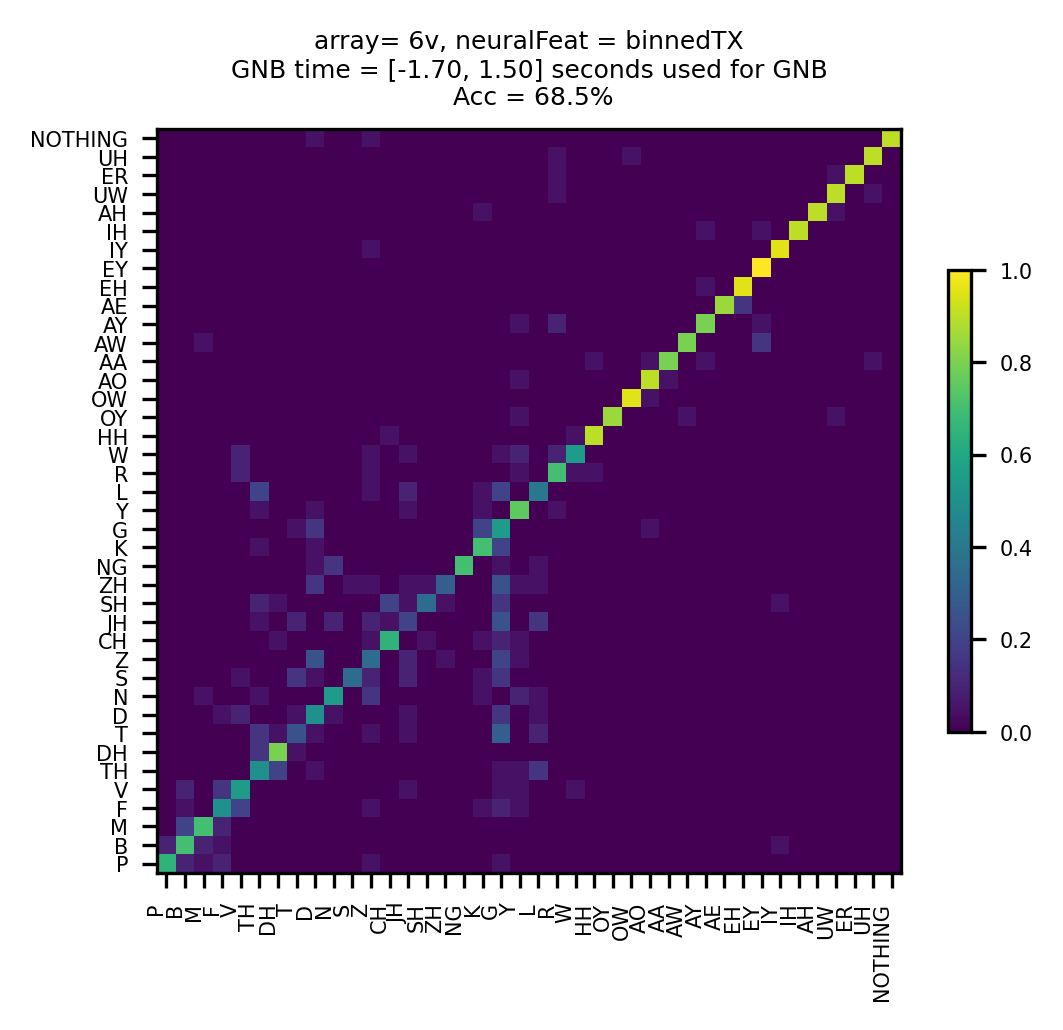

In [23]:
doConfusionPlot = 1
if doConfusionPlot == 1:
    y_pred, unroll_y = gnb_robustWindow(trials_phones_subset, timeIndicesArray, CHs2use)

    accuracyGNB = np.mean(y_pred==unroll_y)*100
    
    print(accuracyGNB)
    # print(bootCI(y_pred, unroll_y))
    # print('CHANCE = '+ str(1/len(orderIdx)))

    title2use = 'array= '+brainArea2use + ', neuralFeat = '+neuralFeature2use+'\n'+'GNB time = '+ dataTimeUsed4GNB+'\n'+' Acc = '+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%'
    plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx,title2use)

    

# PCA 

In [24]:
print(np.shape(trials_phones_subset))
print(np.shape(timeIndicesArray))
print(np.shape(CHs2use))

(40, 20, 160, 128)
(160,)
(128,)


0.008736108
0.5406008
-0.9945117
7.396745


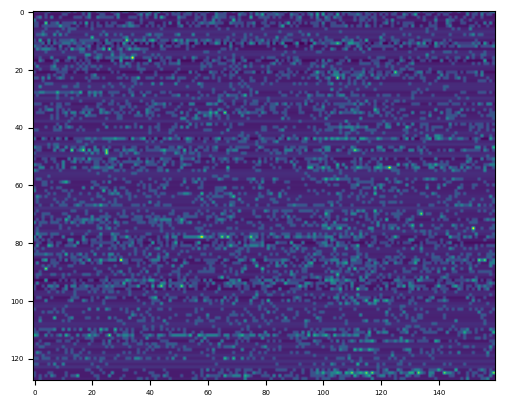

In [25]:
plt.imshow(np.transpose(trials_phones_subset[0][0]))

print(np.mean(trials_phones_subset))
print(np.std(trials_phones_subset))
print(np.min(trials_phones_subset))
print(np.max(trials_phones_subset))

(128000, 128)
principal_components
(128000, 128)


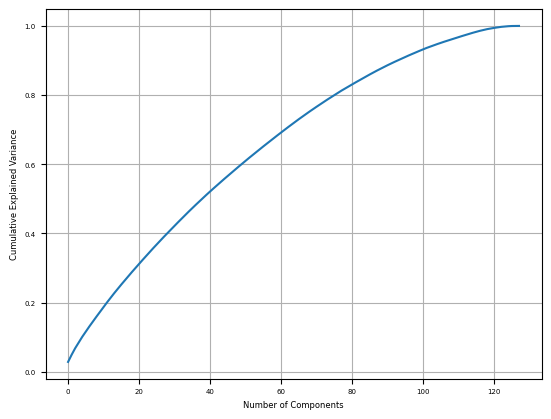

(128000, 128)


In [26]:
dat2use = trials_phones_subset.copy()
# perform trial-concatenated PCA, need to do avoid phoneme-mean PCA since it 
# prevents you from being able to plot phoneme PC trajectories on same XYZ axes (aka bases)

############# Inputs:
# dat2use - (40, 16, 100, 128)

############# Outputs:
# phoneme_pca - unravel PCA output so I have PCs X userDefinedTrimAboutGo_timeStamps_FTL 

############# Load in Data for PCA:
# Turn list into array 
phone_reps_time_ch_data_allCh = np.array(dat2use) # variable name indicates the dimensions info 

############# Index out the channels you desire 
phone_reps_time_ch_data = phone_reps_time_ch_data_allCh[:,:,:,CHs2use]

############# Gather Dimensions of original data structure 
numPhones = np.shape(phone_reps_time_ch_data)[0]
numReps   = np.shape(phone_reps_time_ch_data)[1]
n_trials = numPhones*numReps
numTimeSamples = np.shape(phone_reps_time_ch_data)[2]
numCh     = np.shape(phone_reps_time_ch_data)[3]

############# Step 1: Dimensionality Restructuring: 
### Trial-Concatenated PCA needs n_samples x n_features:

# https://stackoverflow.com/questions/33356442/when-should-i-use-hstack-vstack-vs-append-vs-concatenate-vs-column-stack
# https://betterprogramming.pub/numpy-illustrated-the-visual-guide-to-numpy-3b1d4976de1d#c6af
# Yep, this is computationally a few seconds, but I can follow the book keeping 
for everyPhonemeIdx in np.arange(numPhones):
    onePhone_reps_time_ch_data = phone_reps_time_ch_data[everyPhonemeIdx]
    # print(np.shape(onePhone_reps_time_ch_data))

    for repIdx in np.arange(numReps):
        if (everyPhonemeIdx == 0) & (repIdx == 0):
            nSamples_nFeatures = onePhone_reps_time_ch_data[repIdx]
        else:
            nSamples_nFeatures = np.vstack((nSamples_nFeatures,onePhone_reps_time_ch_data[repIdx]))  

print(np.shape(nSamples_nFeatures))

############# Step 2: Apply PCA
pca = PCA(n_components=numCh)  # Use All ch because if you dont, I got weird n_sample size 
principal_components = pca.fit_transform(nSamples_nFeatures)  # Shape: (n_samples, n_components)

# principal_components output has shape 
print('principal_components')
print(np.shape(principal_components))


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



print(np.shape(principal_components))
# principal_components output has shape (n_samples, n_components), which is (n_phones * n_reps * n_time_points, n_components)

############# Step 3: Reshape Principal Components aka undo vstacks
numSamplesPerPhone = numReps*numTimeSamples

# phone_reps_time_PCs_data = np.full(np.shape(phone_reps_time_ch_data), np.nan)
# # print(np.shape(phone_reps_time_PCs_data))
# for everyPhonemeIdx in np.arange(numPhones):
#     onePhoneRepsTime_ch_data = principal_components[(everyPhonemeIdx)*numSamplesPerPhone:(everyPhonemeIdx+1)*numSamplesPerPhone]
#     # print(np.shape(onePhoneRepsTime_ch_data))
    
#     for repIdx in np.arange(numReps):
#         # print(np.shape(phone_reps_time_PCs_data[everyPhonemeIdx,repIdx]))
#         # print(np.shape(onePhoneRepsTime_ch_data[(repIdx)*numTimeSamples:(repIdx+1)*numTimeSamples]))
#         # phone_reps_time_PCs_data[everyPhonemeIdx,repIdx,,] = onePhoneRepsTime_ch_data[(repIdx-1)*numTimeSamples:repIdx*numTimeSamples]
#         phone_reps_time_PCs_data[everyPhonemeIdx,repIdx] = onePhoneRepsTime_ch_data[(repIdx)*numTimeSamples:
#                                                                                          (repIdx+1)*numTimeSamples]
#         # np.shape(phone_reps_time_PCs_data[0,:15,:450,0])     
#     # return phone_reps_time_PCs_data

############# Step 3: Reshape Principal Components SO IT BEHAVES LIKE VARIABLE LENGTH DATA STRUCTURES SO SAME CODE CAN BE RUN ON IT
phone_reps_time_PCs_FixedLengthdata = []
for phIdx in np.arange(numPhones):
    onePhoneRepsTime_ch_data = principal_components[(phIdx)*numSamplesPerPhone:(phIdx+1)*numSamplesPerPhone]
    # phonePCs_temp = [[None]] * numReps
    phonePCs_temp = [] 
    for repIdx in np.arange(numReps):
        # phonePCs_temp[repIdx] = onePhoneRepsTime_ch_data[(repIdx)*numTimeSamples:(repIdx+1)*numTimeSamples] 
        phonePCs_temp.append(onePhoneRepsTime_ch_data[(repIdx)*numTimeSamples:(repIdx+1)*numTimeSamples] )     
    phone_reps_time_PCs_FixedLengthdata.append(phonePCs_temp)




# Smooth PCAs

In [27]:
type(phone_reps_time_PCs_FixedLengthdata)

list

In [28]:
# Uh Oh Note:
# if you have 50 samples per second:
# One sample = 20 ms

# So, a sigma=10 means the Gaussian kernel spans roughly ±3σ = ±30 samples

# 30 samples ≈ 600 ms, so a sigma=10 smooths over a ~1.2 second window.

# sigma	Rough Time Window (±3σ)	Total Smoothing Window
# 1	±20 ms	~120 ms
# 5	±100 ms	~600 ms
# 10	±200 ms	~1.2 sec
# 15	±300 ms	~1.8 sec

In [29]:
# Data shape: (40 phones, 20 reps, 100 time steps, 128 PCs)
smoothingVal = 1
pcs2use = np.arange(128)

phone_reps_time_PCs_FixedLengthdata = np.array(phone_reps_time_PCs_FixedLengthdata)

numPhones, numReps, timeDurationOnTEMP, numPCs = np.shape(phone_reps_time_PCs_FixedLengthdata)
smoothedPCs = np.empty((numPhones, numReps, timeDurationOnTEMP, len(pcs2use)))

for p in range(numPhones):
    for r in range(numReps):
        for i,pc in enumerate(pcs2use):
            # print(i)
            # print(pc)
            # Smooth along the time axis (length 100)
            time_series = phone_reps_time_PCs_FixedLengthdata[p, r, :, pc]
            smoothed = gaussian_filter1d(time_series, sigma=smoothingVal)
            smoothedPCs[p, r, :, i] = smoothed

print("Smoothed PC tensor:", smoothedPCs.shape)


Smoothed PC tensor: (40, 20, 160, 128)


# Telluride Dev

1️⃣ Clarify Your Neural Data Format => (batch_size = trials, sequence_length = time samples, input_dim = CH)
2️⃣ Decide: Prediction or Modeling Task => 40 choice
3️⃣ Minimal Example Pipeline => 

In [30]:
from jax import random


#### S4 Code from George - S4 Utilities

In [31]:
def cauchy(v,w,z):
    return jax.vmap(lambda ω: (v/(ω-z)).sum())(w)


@functools.partial(jax.jit, static_argnums=5)   # 5 → the position of L
def kernel_DPLR(Lambda, P, B, C, step, L):
    Ω = jnp.exp(-2j * jnp.pi * jnp.arange(L) / L)
    g = (2.0 / step) * (1.0 - Ω) / (1.0 + Ω)
    c = 2.0 / (1.0 + Ω)

    k00 = cauchy(C.conj() * B, g, Lambda)
    k01 = cauchy(C.conj() * P, g, Lambda)
    k10 = cauchy(P.conj() * B, g, Lambda)
    k11 = cauchy(P.conj() * P, g, Lambda)

    at_roots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    return jnp.fft.ifft(at_roots, L).real        # (L,)

def make_DPLR_HiPPO(N):
    n  = jnp.arange(N)
    P  = jnp.sqrt(n+0.5)
    Λ  = -0.5*(n+0.5) + 0j
    B  = jnp.sqrt(2*n+1.0)
    return Λ.astype(jnp.complex64), P.astype(jnp.complex64), B.astype(jnp.complex64)


#### S4 Code from George - S4 Layer

In [32]:
class S4Layer(nn.Module):
    N: int
    L: int
    dropout: float = 0.5
    use_prompt: bool = False
    dtype: any = jnp.float32

    @nn.compact
    def __call__(self, u, *, train: bool):
        log_dt = self.param("log_dt", nn.initializers.uniform(), ())
        step   = jnp.exp(log_dt)                            

        Λ, P, B0 = make_DPLR_HiPPO(self.N)
        Λ = self.param("Λ", lambda *_: Λ)
        P = self.param("P", lambda *_: P)
        B = self.param("B", lambda *_: B0)
        C = self.param("C", nn.initializers.normal(stddev=0.5), (self.N,))

        kernel = kernel_DPLR(Λ, P, B, C, step, self.L)       
        L = kernel.shape[0]

        pad = jnp.concatenate([u,
                               jnp.zeros(u.shape[:-2] + (L, u.shape[-1]),
                                         dtype=u.dtype)], axis=1)
        U = jnp.fft.rfft(pad, n=2*L, axis=1)                
        K = jnp.fft.rfft(jnp.pad(kernel, (0, L)), axis=0)    
        K = K[None, :, None]                               
        y = jnp.fft.irfft(U * K, n=2*L, axis=1)[..., :u.shape[1], :]

        y = nn.Dropout(self.dropout)(y, deterministic=not train)
        if self.use_prompt:
            prompt = self.param("prompt", nn.initializers.normal(),
                                (1, 1, u.shape[-1]))
            y = y + prompt

        #### residual connection = y+u
        # u is the input sequence to the S4 layer.
        # y is the output of the convolutional kernel operation inside the layer.
        # Adding y + u means the layer’s output is the original input plus some learned change (y).
        
        #### latent state sequence = y
        return y + u, y


#### S4 Code from George - S4 Phoneme Classifier

In [33]:
class S4PhonemeClassifier(nn.Module):
    d_model: int                     
    n_layers: int = 3
    seq_len:  int = 100
    n_classes: int = 4
    dropout:  float = 0.3
    use_prompt: bool = True

    @nn.compact
    def __call__(self, x, *, train: bool):
        # x : (B, T, C)   C == d_model
        h = nn.Dense(self.d_model)(x)
        ssm_activations = []
        for _ in range(self.n_layers):
            h,ssm_out = S4Layer(self.d_model, self.seq_len,
                        dropout=self.dropout,
                        use_prompt=self.use_prompt)(h, train=train)
            ssm_activations.append(ssm_out)
        h = h.mean(axis=1)              # global avg-pool over time
        logits = nn.Dense(self.n_classes)(h)
        return logits,ssm_activations


In [34]:
import pickle, pathlib, time

CKPT_DIR = pathlib.Path("checkpoints")
CKPT_DIR.mkdir(exist_ok=True)

def save_ckpt(params, path):
    with open(path, "wb") as f:
        pickle.dump(params, f)

def load_ckpt(path):
    with open(path, "rb") as f:
        return pickle.load(f)
        
def loss_and_acc(params, x, y, rng_d):
    logits,ssm_activations = model.apply({'params': params}, x, train=True,
                         rngs={'dropout': rng_d})
    loss   = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    acc    = (logits.argmax(-1) == y).mean()
    return loss, acc

loss_and_acc = jax.jit(loss_and_acc)

@jax.jit
def train_step(params, opt_state, x, y, rng_d):
    (loss, acc), grads = jax.value_and_grad(loss_and_acc, has_aux=True)(
        params, x, y, rng_d
    )
    updates, opt_state = tx.update(grads, opt_state, params)
    params             = optax.apply_updates(params, updates)
    return params, opt_state, loss, acc


#### Manage Data, Data splits, and param defs

In [35]:
# componentCoordsSmoothed_aboutTEMP is (40, 16, 4 PCs, 100)
# Shape: (40 classes, 16 reps, 128 PCs, 100 time)

typeData ='rawData'
# typeData ='rawPCs'
# typeData ='SmoothedPCs'

numPCs = 128
print(numPCs)
numPCsArray = np.arange(0,numPCs)

if typeData =='SmoothedPCs':
    data4ssm = smoothedPCs[:,:,:,numPCsArray]
elif typeData =='rawPCs':
    data4ssm = phone_reps_time_PCs_FixedLengthdata[:,:,:,numPCsArray]
elif typeData =='rawData':
    data4ssm = np.array(trials_phones_subset)

if typeData == 'SmoothedPCs':
    dataSettingStr = '%%%%%% SSM DATA = '+ typeData + ' , SmoothingVal = '+str(smoothingVal)+ ' , INPUT CHs = '+ str(numPCs)
else:
    dataSettingStr = '%%%%%% SSM DATA = '+ typeData + ' , INPUT CHs = '+ str(numPCs)

print(dataSettingStr)

print('data4ssm')
print(np.shape(data4ssm))

print("Data mean:", data4ssm.mean())
print("Data std:", data4ssm.std())
print("Max value:", data4ssm.max())
print("Min value:", data4ssm.min())

# Transpose to match (classes, reps, time, features)
data = jnp.transpose(data4ssm, (0, 1, 3, 2))  # Shape: (40, 16, 100, 128)
mean = np.mean(data)
std = np.std(data)
data_norm = (data - mean) / std

classes, reps, time_steps, input_dim = data.shape
labels = jnp.repeat(jnp.arange(classes), reps)

# Flatten data for looping
print('data')
print(np.shape(data))

# Flatten data and fix shape
flat_data = data.reshape(-1, time_steps, input_dim).swapaxes(1, 2)
flat_labels = labels

# print(np.shape(flat_labels))
# print(flat_labels) # yep, reps of each phoneme label 

X, y = shuffle(flat_data, flat_labels, random_state=0)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(type(X))
print(np.shape(X))

print(type(y))
print(np.shape(y))

128
%%%%%% SSM DATA = rawData , INPUT CHs = 128
data4ssm
(40, 20, 160, 128)
Data mean: 0.008736108
Data std: 0.5406008
Max value: 7.396745
Min value: -0.9945117
data
(40, 20, 128, 160)
<class 'jaxlib.xla_extension.ArrayImpl'>
(800, 160, 128)
<class 'jaxlib.xla_extension.ArrayImpl'>
(800,)


#### Heavy Lifting 

In [36]:
#### Grid Search Idea 
# 1. unitsPerLayer     → try 128, 256, 512
# 2. learning rate → try 1e-3, 3e-3*, 5e-3
# 3. n_layers    → try 2, 4*, 6
# 4. dropout     → 0.3, 0.5 .8
# 5. weight decay → 1e-3, 1e-2, 1e-1



In [37]:
# XVAL SPLITTING  10-folx val like Haro
start = time.time()

EPOCHS = 100
BATCH = 64
    
PEAK_LR     = 3e-3   # 5e-3, 3e-3,1e-3   
WEIGHT_DEC  = 1e-2           
CLIP_NORM   = 1.0             

numLayers = 4
unitsPerLayer = len(CHs2use) # len(CHs2use) / len(CHs2use)*2 / len(CHs2use)*4

###### Training Loop  like Haro 
y_true_all = []
y_pred_all = []
accuracies_xvalFolds = []
for fold, (train_modeling_idx, test_idx) in enumerate(kf.split(X, y)):
    ################## Data Split Management ##################
    print(f"\n=== Fold {fold + 1} ===")
    X_modeling, X_test = X[train_modeling_idx], X[test_idx]
    y_modeling, y_test = y[train_modeling_idx], y[test_idx]

    ##### Now split X_modeling into train and validation sets
    X_train, X_val = train_test_split(
        X_modeling, test_size=0.111, random_state=fold, stratify=y_modeling)
    
    y_train, y_val = train_test_split(
        y_modeling, test_size=0.111, random_state=fold, stratify=y_modeling)
    
    ################## Heavy Lifting - Build S4 Model ##################
    model = S4PhonemeClassifier(
        d_model   = unitsPerLayer, 
        n_layers  = numLayers,
        seq_len   = X.shape[1],
        n_classes = len(cues2use))
    
    rng         = jax.random.PRNGKey(fold)
    params      = model.init({'params': rng, 'dropout': rng}, X[:1], train=True)['params']
    TOTAL_STEPS = EPOCHS * ((len(y_train) + BATCH - 1) // BATCH)
    
    schedule = optax.cosine_onecycle_schedule(# 1-cycle LR (↑ then long ↓)
        transition_steps = TOTAL_STEPS,
        peak_value       = PEAK_LR,
        pct_start        = 0.3,        
        div_factor       = 25.0,       
        final_div_factor = 1e4)                               
    
    tx = optax.chain(optax.clip_by_global_norm(CLIP_NORM),      
        optax.adamw(learning_rate=schedule,
                    weight_decay=WEIGHT_DEC))
    
    opt_state = tx.init(params)

    ################## Heavy Lifting - Train S4 Model ##################
    train_key  = jax.random.PRNGKey(fold)                          # running key for dropout
    perm  = jax.random.permutation(train_key, len(y))
    step_counter = 0


    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        ##### Shuffle and batch over X_train, y_train
        idx = jax.random.permutation(train_key, len(y_train))
        for i in range(0, len(idx), BATCH):
            sl = idx[i:i+BATCH]
            train_key, sub = jax.random.split(train_key)
            params, opt_state, loss, acc = train_step(
                params, opt_state, X_train[sl], y_train[sl], sub)
            step_counter += 1

        ##### Validation evaluation
        logits_val,ssm_activations_val = model.apply({'params': params}, X_val, train=False)
        val_acc = (logits_val.argmax(-1) == y_val).mean()
    
        if epoch == 1 or val_acc > best_val_acc:
            best_val_acc = float(val_acc)
            best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            print(f"Early stop at epoch {epoch} – best val_acc={best_val_acc:.3f}")
            break
            
        cur_lr = schedule(step_counter)
        
        if epoch % 5 == 0:
            print(f"epoch {epoch:02d}  lr {float(cur_lr):.2e}  "
                  f"train-acc {acc:.3f}  val-acc {val_acc:.3f}  "
                  f"time {time.time() - t0:.1f}s  best {best_val_acc:.3f}")


    # Test evaluation using best_params
    logits_test,ssm_activations_test = model.apply({'params': best_params}, X_test, train=False)
    test_acc = (logits_test.argmax(-1) == y_test).mean()
    print(f"Fold {fold + 1} test accuracy: {test_acc:.3f}")
    accuracies_xvalFolds.append(test_acc)

# Final summary
end = time.time()
print(f"Elapsed time: {end - start:.4f} seconds")

print(dataSettingStr)
print('Mean Test Acc = ' + str(np.mean(accuracies_xvalFolds)) + ' (SD = '+str(np.std(accuracies_xvalFolds))+')')




=== Fold 1 ===
epoch 05  lr 3.13e-04  train-acc 0.047  val-acc 0.025  time 4.9s  best 0.038
epoch 10  lr 8.40e-04  train-acc 0.281  val-acc 0.125  time 7.2s  best 0.125
epoch 15  lr 1.56e-03  train-acc 0.953  val-acc 0.675  time 9.5s  best 0.675
epoch 20  lr 2.28e-03  train-acc 0.984  val-acc 0.625  time 11.9s  best 0.675
epoch 25  lr 2.81e-03  train-acc 1.000  val-acc 0.713  time 14.3s  best 0.713
epoch 30  lr 3.00e-03  train-acc 0.969  val-acc 0.663  time 16.7s  best 0.713
Early stop at epoch 35 – best val_acc=0.713
Fold 1 test accuracy: 0.713

=== Fold 2 ===
epoch 05  lr 3.13e-04  train-acc 0.031  val-acc 0.025  time 2.4s  best 0.025
epoch 10  lr 8.40e-04  train-acc 0.031  val-acc 0.025  time 4.7s  best 0.025
epoch 15  lr 1.56e-03  train-acc 0.219  val-acc 0.225  time 7.0s  best 0.225
epoch 20  lr 2.28e-03  train-acc 0.984  val-acc 0.700  time 9.3s  best 0.713
epoch 25  lr 2.81e-03  train-acc 1.000  val-acc 0.663  time 11.6s  best 0.713
Early stop at epoch 28 – best val_acc=0.713
F

In [42]:
print(np.shape(layer_activations))

(80, 160, 128)


# Visualize the State Space Activations/Latent Space for test set

In [46]:
def pcaSsmLayerClean(layer_activations, unitsPerLayer,y_test):
    n_trials, numTimeSamples, numCh = layer_activations.shape

    # Reshape to (n_trials * numTimeSamples, numCh)
    nSamples_nFeatures = layer_activations.reshape(-1, numCh)

    # Apply PCA
    pca = PCA(n_components=numCh)
    principal_components = pca.fit_transform(nSamples_nFeatures)
    
    # Reshape principal components back into (n_trials, time, PCs)
    pcs_unraveled = principal_components.reshape(n_trials, numTimeSamples, -1)

    # Compute explained Variance
    explainedVar = np.cumsum(pca.explained_variance_ratio_)
    
    
    ######### Reshape so it runs on my 3d trajectory visualizer 
    # pcs_unraveled: (80, 100, 128)
    # y_test: labels for each trial, should be integers in 0–39
    if pcs_unraveled.shape[0] != len(y_test):
        raise ValueError("Mismatch between pcs_unraveled and y_test lengths.")
    
    # Step A: Rearrange to (trials, PCs, time)
    pcs_transposed = np.transpose(pcs_unraveled, (0, 2, 1))  # shape: (80, 128, 100)
    print(np.shape(pcs_transposed))
    
    # Step B: Initialize output container
    n_phonemes = 40
    reps_per_phoneme = 2
    n_pcs = pcs_transposed.shape[1]
    n_time = pcs_transposed.shape[2]
    pcs_structured = np.zeros((n_phonemes, reps_per_phoneme, n_pcs, n_time))
    
    # Step C: Fill data into phoneme × rep slots based on y_test
    y_test_np = np.array(y_test).astype(int)

    counts = {k: 0 for k in range(n_phonemes)}
    for i, label in enumerate(y_test_np):
        if label not in counts:
            print(f"Warning: unexpected label {label}, skipping trial {i}")
            continue
        rep_idx = counts[label]
        if rep_idx >= reps_per_phoneme:
            print(f"Warning: too many reps for phoneme {label}, skipping trial {i}")
            continue
        pcs_structured[label, rep_idx] = pcs_transposed[i]
        counts[label] += 1
    
    print("Done reshaping.")
    print("pcs_structured shape:", pcs_structured.shape)  # should be (40, 2, 128, 100)

    # Return cumulative explained variance and reshaped PCs
    return explainedVar, pcs_structured


(80, 128, 160)
Done reshaping.
pcs_structured shape: (40, 2, 128, 160)
(80, 128, 160)
Done reshaping.
pcs_structured shape: (40, 2, 128, 160)
(80, 128, 160)
Done reshaping.
pcs_structured shape: (40, 2, 128, 160)
(80, 128, 160)
Done reshaping.
pcs_structured shape: (40, 2, 128, 160)


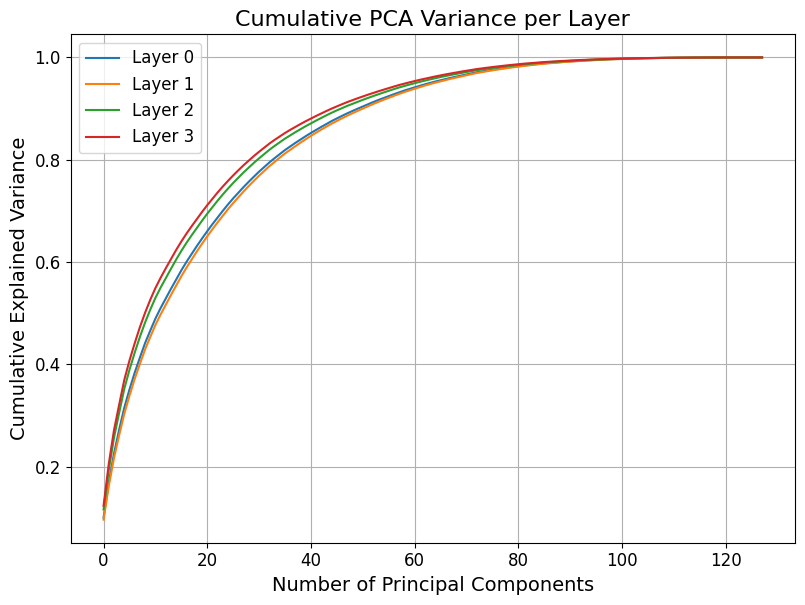

In [47]:
# Prepare a container for all layers
pca_results = []

for layIdx in range(numLayers):
    layer_activations = np.array(ssm_activations_test[layIdx])  # (trials, time, d_model)
    explained_var, pcs_unraveled = pcaSsmLayerClean(layer_activations, unitsPerLayer, np.array(y_test).astype(int))
    
    # Store results in a dict per layer
    layer_result = {
        'layer_idx': layIdx,
        'explained_variance': explained_var,  # 1D array of length n_components
        'pcs_unraveled': pcs_unraveled       # shape (trials, time, components)
    }
    pca_results.append(layer_result)

# Now you can plot all explained variance curves easily:
plt.figure(figsize=(8, 6))
for result in pca_results:
    plt.plot(result['explained_variance'], label=f"Layer {result['layer_idx']}")

plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative PCA Variance per Layer', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



In [ ]:
break

#### IPA Mapping

In [50]:
def get_mappings(mappingID):
    mapping_idx_to_phoneme = {'0':'B AA','1':'CH AA','2':'SIL','3':'D AA','4':'F AA',
                     '5':'G AA','6':'HH AA','7':'JH AA','8':'K AA',
                     '9':'L AA','10':'ER','11':'M AA','12':'N AA','13':'NG AA',
                     '14':'P AA','15':'R AA','16':'S AA','17':'SH AA','18':'DH AA','19':'T AA','20':'TH AA',
                     '21':'V AA','22':'W AA','23':'Y AA','24':'Z AA','25':'ZH AA',
                     '26':'OY','27':'EH','28':'EY','29':'UH','30':'IY','31':'OW',
                     '32':'UW','33':'IH','34':'AA','35':'AW','36':'AY','37':'AH','38':'AO','39':'AE'}
    
    mapping_cues_to_phonemes = {
        'Bah':'B AA','Chah':'CH AA','DO_NOTHING':'SIL','Dah':'D AA', 'Fah':'F AA','Gah':'G AA',
        'Hah':'HH AA','Jah':'JH AA','Kah':'K AA','Lah':'L AA','LettER':'ER','Mah':'M AA','Nah':'N AA',
        'Ngah':'NG AA','Pah':'P AA','Rah':'R AA','Sah':'S AA','Shah':'SH AA','THe':'DH AA',
        'Tah':'T AA','Thah':'TH AA','Vah':'V AA','Wah':'W AA','Yah':'Y AA','Zah':'Z AA','Zhah':'ZH AA',
        'chOIce':'OY','drEss':'EH','fAce':'EY','fOOt':'UH','flEEce':'IY','gOAt':'OW','gOOse':'UW',
        'kIt':'IH','lOt':'AA','mOUth':'AW','prIce':'AY','strUt':'AH','thOUGHt':'AO','trAp':'AE'}

    mapping_phoneme_to_arpabet = {'B AA': 'B' , 'CH AA': 'CH' , 'SIL': '|' , 'D AA': 'D' , 'F AA': 'F' , 'G AA': 'G' , 'HH AA': 'HH' , 
    'JH AA': 'JH' , 'K AA': 'K' , 'L AA': 'L' , 'ER': 'ER' , 'M AA': 'M' , 'N AA': 'N' , 'NG AA': 'NG' ,
    'P AA': 'P' , 'R AA': 'R' , 'S AA': 'S' , 'SH AA': 'SH' , 'DH AA': 'DH' , 'T AA': 'T' , 'TH AA': 'TH' ,
    'V AA': 'V' , 'W AA': 'W' , 'Y AA': 'Y' , 'Z AA': 'Z' , 'ZH AA': 'ZH' , 
    'OY': 'OY' , 'OW': 'OW' , 
    'AO': 'AO' , 'AA': 'AA' , 'AW': 'AW' , 'AY': 'AY' , 'AE': 'AE' , 'EH': 'EH' , 
    'EY': 'EY' , 'IY': 'IY' , 'IH': 'IH' , 'AH': 'AH' , 'UW': 'UW' , 'UH': 'UH' }

    mapping_arpabet_to_phoneme = {value: key for key, value in mapping_phoneme_to_arpabet.items()}
    
    #https://stackoverflow.com/questions/1031851/how-do-i-exchange-keys-with-values-in-a-dictionary
    mapping_arpabet_to_phoneme = dict((v,k) for k,v in mapping_phoneme_to_arpabet.items())
    # print(mapping_arpabet_to_phoneme)
    
    mapping_arpabet_to_useful = {'B': 'B' , 'CH': 'CH' , '|': 'SIL' , 'D': 'D' , 'F': 'F' , 'G': 'G' , 'HH': 'H' , 
        'JH': 'J' , 'K': 'K' , 'L': 'L' , 'ER': 'lett-ER' , 'M': 'M' , 'N': 'N' , 'NG': 'NG' ,
        'P': 'P' , 'R': 'R' , 'S': 'S' , 'SH': 'SH' , 'DH': 'TH-e' , 'T': 'T' , 'TH': 'TH-in' ,
        'V': 'V' , 'W': 'W' , 'Y': 'Y' , 'Z': 'Z' , 'ZH': 'a-SI-a' , 
        'OY': 'ch-OI-ce' , 'EH': 'dr-E-ss', 
        'EY': 'f-A-ce' , 'UH': 'f-OO-t' , 'IY': 'fl-EE-ce' , 'OW': 'g-OA-t' , 
        'UW': 'g-OO-se' , 'IH': 'k-I-t' , 'AA': 'l-O-t' ,
        'AW': 'm-OU-th' , 'AY': 'pr-I-ce' , 'AH': 'str-U-t' , 'AO': 'th-OU-GHt' , 'AE': 'tr-A-p'}

    phoneme_to_consoVowelSil = {'P AA': 'consonant' , 'B AA': 'consonant' , 'M AA': 'consonant' , 'F AA': 'consonant' , 'V AA': 'consonant' , 
                     'TH AA': 'consonant' , 'DH AA': 'consonant' , 
                     'T AA': 'consonant' , 'D AA': 'consonant' , 'N AA': 'consonant' , 'S AA': 'consonant' , 'Z AA': 'consonant' , 
                     'CH AA': 'consonant' , 'JH AA': 'consonant' , 'SH AA': 'consonant' , 'ZH AA': 'consonant' , 
                     'NG AA': 'consonant' , 'K AA': 'consonant' , 'G AA': 'consonant' , 
                     'Y AA': 'consonant' , 'L AA': 'consonant' , 'R AA': 'consonant' , 'W AA': 'consonant' , 
                     'HH AA': 'consonant' , 'OY': 'vowel' , 'OW': 'vowel' , 
                     'AO': 'vowel' , 'AA': 'vowel' , 'AW': 'vowel' , 'AY': 'vowel' , 'AE': 'vowel' , 'EH': 'vowel' , 
                     'EY': 'vowel' , 'IY': 'vowel' , 'IH': 'vowel' , 'AH': 'vowel' , 'UW': 'vowel' , 'ER': 'vowel' , 'UH': 'vowel' , 'SIL': 'silence'}


    phoneme_to_place = {'P AA': 'Labial' , 'B AA': 'Labial' , 'M AA': 'Labial' , 'F AA': 'Labial' , 'V AA': 'Labial' , 
                     'TH AA': 'Dental' , 'DH AA': 'Dental' , 
                     'T AA': 'Alveolar' , 'D AA': 'Alveolar' , 'N AA': 'Alveolar' , 'S AA': 'Alveolar' , 'Z AA': 'Alveolar' , 
                     'CH AA': 'Post-Alveolar' , 'JH AA': 'Post-Alveolar' , 'SH AA': 'Post-Alveolar' , 'ZH AA': 'Post-Alveolar' , 
                     'NG AA': 'Palatal/Velar' , 'K AA': 'Palatal/Velar' , 'G AA': 'Palatal/Velar' , 
                     'Y AA': 'Approximant' , 'L AA': 'Approximant' , 'R AA': 'Approximant' , 'W AA': 'Approximant' , 
                     'HH AA': 'Glottal' , 'OY': 'vowel' , 'OW': 'vowel' , 
                     'AO': 'vowel' , 'AA': 'vowel' , 'AW': 'vowel' , 'AY': 'vowel' , 'AE': 'vowel' , 'EH': 'vowel' , 
                     'EY': 'vowel' , 'IY': 'vowel' , 'IH': 'vowel' , 'AH': 'vowel' , 'UW': 'vowel' , 'ER': 'vowel' , 'UH': 'vowel' , 'SIL': 'silence'}
    
    phoneme_to_manner = {'P AA': 'Plosive' , 'B AA': 'Plosive' , 'M AA': 'Nasal' , 'F AA': 'Non-sibilant fricative' , 'V AA': 'Non-sibilant fricative' , 
                     'TH AA': 'Non-sibilant fricative' , 'DH AA': 'Non-sibilant fricative' , 
                     'T AA': 'Plosive' , 'D AA': 'Plosive' , 'N AA': 'Nasal' , 'S AA': 'Sibilant fricative' , 'Z AA': 'Sibilant fricative' , 
                     'CH AA': 'Sibilant affricate' , 'JH AA': 'Sibilant affricate' , 'SH AA': 'Sibilant fricative' , 'ZH AA': 'Sibilant fricative' , 
                     'NG AA': 'Nasal' , 'K AA': 'Plosive' , 'G AA': 'Plosive' , 
                     'Y AA': 'Approximant' , 'L AA': 'Approximant' , 'R AA': 'Approximant' , 'W AA': 'Approximant' , 
                     'HH AA': 'Non-sibilant fricative' , 'OY': 'vowel' , 'OW': 'vowel' , 
                     'AO': 'vowel' , 'AA': 'vowel' , 'AW': 'vowel' , 'AY': 'vowel' , 'AE': 'vowel' , 'EH': 'vowel' , 
                     'EY': 'vowel' , 'IY': 'vowel' , 'IH': 'vowel' , 'AH': 'vowel' , 'UW': 'vowel' , 'ER': 'vowel' , 'UH': 'vowel' , 'SIL': 'silence'}

    phoneme_to_voicing = {'P AA': 'voiceless' , 'B AA': 'voiced' , 'M AA': 'voiced' , 'F AA': 'voiceless' , 'V AA': 'voiced' , 
                     'TH AA': 'voiceless' , 'DH AA': 'voiced' , 
                     'T AA': 'voiceless' , 'D AA': 'voiced' , 'N AA': 'voiced' , 'S AA': 'voiceless' , 'Z AA': 'voiced' , 
                     'CH AA': 'voiceless' , 'JH AA': 'voiced' , 'SH AA': 'voiceless' , 'ZH AA': 'voiced' , 
                     'NG AA': 'voiced' , 'K AA': 'voiceless' , 'G AA': 'voiced' , 
                     'Y AA': 'voiced' , 'L AA': 'voiced' , 'R AA': 'voiced' , 'W AA': 'voiced' , 
                     'HH AA': 'voiceless' , 'OY': 'vowel' , 'OW': 'vowel' , 
                     'AO': 'vowel' , 'AA': 'vowel' , 'AW': 'vowel' , 'AY': 'vowel' , 'AE': 'vowel' , 'EH': 'vowel' , 
                     'EY': 'vowel' , 'IY': 'vowel' , 'IH': 'vowel' , 'AH': 'vowel' , 'UW': 'vowel' , 'ER': 'vowel' , 'UH': 'vowel' , 'SIL': 'silence'}

    phoneme_to_vowelsType = {'P AA': 'consonant' , 'B AA': 'consonant' , 'M AA': 'consonant' , 'F AA': 'consonant' , 'V AA': 'consonant' , 
                     'TH AA': 'consonant' , 'DH AA': 'consonant' , 
                     'T AA': 'consonant' , 'D AA': 'consonant' , 'N AA': 'consonant' , 'S AA': 'consonant' , 'Z AA': 'consonant' , 
                     'CH AA': 'consonant' , 'JH AA': 'consonant' , 'SH AA': 'consonant' , 'ZH AA': 'consonant' , 
                     'NG AA': 'consonant' , 'K AA': 'consonant' , 'G AA': 'consonant' , 
                     'Y AA': 'consonant' , 'L AA': 'consonant' , 'R AA': 'consonant' , 'W AA': 'consonant' , 
                     'HH AA': 'consonant' , 
                     'OY': 'diphthong' , 'OW': 'diphthong' , 
                     'AO': 'vowelNoTransition' , 'AA': 'vowelNoTransition' , 'AW': 'diphthong' , 'AY': 'diphthong' , 'AE': 'vowelNoTransition' , 'EH': 'vowelNoTransition' , 
                     'EY': 'diphthong' , 'IY': 'vowelNoTransition' , 'IH': 'vowelNoTransition' , 'AH': 'vowelNoTransition' , 'UW': 'vowelNoTransition' , 'ER': 'rhotic' , 'UH': 'vowelNoTransition' , 
                             'SIL': 'silence'}


    mapping_arpabet_to_useful = {'B': 'B' , 'CH': 'CH' , '|': 'SIL' , 'D': 'D' , 'F': 'F' , 'G': 'G' , 'HH': 'H' , 
        'JH': 'J' , 'K': 'K' , 'L': 'L' , 'ER': 'lett-ER' , 'M': 'M' , 'N': 'N' , 'NG': 'NG' ,
        'P': 'P' , 'R': 'R' , 'S': 'S' , 'SH': 'SH' , 'DH': 'TH-e' , 'T': 'T' , 'TH': 'TH-in' ,
        'V': 'V' , 'W': 'W' , 'Y': 'Y' , 'Z': 'Z' , 'ZH': 'a-SI-a' , 
        'OY': 'ch-OI-ce' , 'EH': 'dr-E-ss', 
        'EY': 'f-A-ce' , 'UH': 'f-OO-t' , 'IY': 'fl-EE-ce' , 'OW': 'g-OA-t' , 
        'UW': 'g-OO-se' , 'IH': 'k-I-t' , 'AA': 'l-O-t' ,
        'AW': 'm-OU-th' , 'AY': 'pr-I-ce' , 'AH': 'str-U-t' , 'AO': 'th-OU-GHt' , 'AE': 'tr-A-p'}
    
    ######################### BASICS 
    if mappingID =='mapping_idx_to_phoneme':
        mapping = mapping_idx_to_phoneme
        
    elif mappingID == 'cue_to_phoneme':  
        mapping = mapping_cues_to_phonemes
    
    ######################### PHONEME TO IPA FEATURE    
    elif mappingID == 'phoneme_to_consoVowelSil': 
        mapping = phoneme_to_consoVowelSil
        
    elif mappingID == 'phoneme_to_place': 
        mapping = phoneme_to_place
        
    elif mappingID == 'phoneme_to_manner': 
        mapping = phoneme_to_manner
        
    elif mappingID == 'phoneme_to_voicing': 
        mapping = phoneme_to_voicing
        
    elif mappingID == 'phoneme_to_vowelsType': 
        mapping = phoneme_to_vowelsType
    
        
        
     ######################### USEFUL TO IPA FEATURE    
    elif mappingID == 'arpabet_to_useful':
        mapping = mapping_arpabet_to_useful
    elif mappingID == 'arpabet_to_phoneme':
        mapping = mapping_arpabet_to_phoneme

    elif mappingID == 'useful_to_consoVowelSil': 
        mapping_useful_to_consoVowelSil = {}
        for key, value in mapping_arpabet_to_useful.items():
            phoneme2use   = mapping_arpabet_to_phoneme.get(key) # use mapping_arpabet_to_useful arpabet KEY to get phoneme2use from mapping_arpabet_to_phoneme
            ipa_value = phoneme_to_consoVowelSil.get(phoneme2use)  # use phoneme2use to get consoVowelSil from phoneme_to_consoVowelSil
            mapping_useful_to_consoVowelSil[value] = ipa_value # here, assign consoVowelSil to mapping_arpabet_to_useful useful VALUE
        mapping =  mapping_useful_to_consoVowelSil

    elif mappingID == 'useful_to_place': 
        mapping_useful_to_place = {}
        for key, value in mapping_arpabet_to_useful.items():
            phoneme2use   = mapping_arpabet_to_phoneme.get(key) # use mapping_arpabet_to_useful arpabet KEY to get phoneme2use from mapping_arpabet_to_phoneme
            ipa_value = phoneme_to_place.get(phoneme2use)  # use phoneme2use to get consoVowelSil from phoneme_to_consoVowelSil
            mapping_useful_to_place[value] = ipa_value # here, assign consoVowelSil to mapping_arpabet_to_useful useful VALUE
        mapping =  mapping_useful_to_place        
        
    elif mappingID == 'useful_to_manner': 
        mapping_useful_to_manner = {}
        for key, value in mapping_arpabet_to_useful.items():
            phoneme2use   = mapping_arpabet_to_phoneme.get(key) # use mapping_arpabet_to_useful arpabet KEY to get phoneme2use from mapping_arpabet_to_phoneme
            ipa_value = phoneme_to_manner.get(phoneme2use)  # use phoneme2use to get consoVowelSil from phoneme_to_consoVowelSil
            mapping_useful_to_manner[value] = ipa_value # here, assign consoVowelSil to mapping_arpabet_to_useful useful VALUE
        mapping =  mapping_useful_to_manner   
        
    elif mappingID == 'useful_to_voicing': 
        mapping_useful_to_voicing = {}
        for key, value in mapping_arpabet_to_useful.items():
            phoneme2use   = mapping_arpabet_to_phoneme.get(key) # use mapping_arpabet_to_useful arpabet KEY to get phoneme2use from mapping_arpabet_to_phoneme
            ipa_value = phoneme_to_voicing.get(phoneme2use)  # use phoneme2use to get consoVowelSil from phoneme_to_consoVowelSil
            mapping_useful_to_voicing[value] = ipa_value # here, assign consoVowelSil to mapping_arpabet_to_useful useful VALUE
        mapping =  mapping_useful_to_voicing
   

    ######################### CUE TO IPA FEATURE 
    
    elif mappingID == 'cue_to_consoVowelSil':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_cues_to_consoVowelSil = {}
        for key, value in mapping_cues_to_phonemes.items():
            mapping_cues_to_consoVowelSil[key] = phoneme_to_consoVowelSil.get(value)  
        mapping =  mapping_cues_to_consoVowelSil

    elif mappingID == 'cue_to_place':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_cues_to_place = {}
        for key, value in mapping_cues_to_phonemes.items():
            mapping_cues_to_place[key] = phoneme_to_place.get(value) 
        mapping =  mapping_cues_to_place
        
    elif mappingID == 'cue_to_manner':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_cues_to_manner = {}
        for key, value in mapping_cues_to_phonemes.items():
            mapping_cues_to_manner[key] = phoneme_to_manner.get(value)   
        mapping =  mapping_cues_to_manner
        
    elif mappingID == 'cue_to_voicing':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_cues_to_voicing = {}
        for key, value in mapping_cues_to_phonemes.items():
            mapping_cues_to_voicing[key] = phoneme_to_voicing.get(value)
        mapping =  mapping_cues_to_voicing

    elif mappingID == 'cue_to_vowelsType':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_cues_to_vowelsType = {}
        for key, value in mapping_cues_to_phonemes.items():
            mapping_cues_to_vowelsType[key] = phoneme_to_vowelsType.get(value)
        mapping =  mapping_cues_to_vowelsType
        
    
     
    ######################### IDX TO IPA FEATURE 
    elif mappingID == 'mapping_idx_to_cue':
        #https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
        # list out keys and values separately
        cue_list = list(mapping_cues_to_phonemes.keys())
        idx_list = list(mapping_idx_to_phoneme.keys())
        
        mapping_idx_to_cue = {}
        for key, value in mapping_idx_to_phoneme.items():
            position = idx_list.index(key)
            # print(cue_list[position])
            mapping_idx_to_cue[key] = cue_list[position]
            
        mapping =  mapping_idx_to_cue

    elif mappingID == 'idx_to_consoVowelSil':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_idx_to_consoVowelSil = {}
        for key, value in mapping_idx_to_phoneme.items():
            mapping_idx_to_consoVowelSil[key] = phoneme_to_consoVowelSil.get(value)
        mapping =  mapping_idx_to_consoVowelSil

    elif mappingID == 'idx_to_place':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_idx_to_place = {}
        for key, value in mapping_idx_to_phoneme.items():
            mapping_idx_to_place[key] = phoneme_to_place.get(value)
        mapping =  mapping_idx_to_place

    elif mappingID == 'idx_to_manner':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_idx_to_manner = {}
        for key, value in mapping_idx_to_phoneme.items():
            mapping_idx_to_manner[key] = phoneme_to_manner.get(value)
        mapping =  mapping_idx_to_manner

    elif mappingID == 'idx_to_voicing':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_idx_to_voicing = {}
        for key, value in mapping_idx_to_phoneme.items():
            mapping_idx_to_voicing[key] = phoneme_to_voicing.get(value)
        mapping =  mapping_idx_to_voicing

    ######################### ARPABET TO IPA FEATURE 
    elif mappingID == 'arpabet_to_consoVowelSil':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_arpabet_to_consoVowelSil = {}
        for key, value in mapping_arpabet_to_phoneme.items():
            mapping_arpabet_to_consoVowelSil[key] = phoneme_to_consoVowelSil.get(value)
        mapping =  mapping_arpabet_to_consoVowelSil

    elif mappingID == 'arpabet_to_place':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_arpabet_to_place = {}
        for key, value in mapping_arpabet_to_phoneme.items():
            mapping_arpabet_to_place[key] = phoneme_to_place.get(value)
        mapping =  mapping_arpabet_to_place

    elif mappingID == 'arpabet_to_manner':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_arpabet_to_manner = {}
        for key, value in mapping_arpabet_to_phoneme.items():
            mapping_arpabet_to_manner[key] = phoneme_to_manner.get(value)
        mapping =  mapping_arpabet_to_manner

    elif mappingID == 'arpabet_to_voicing':
        #https://www.educative.io/answers/how-to-copy-a-dictionary-in-python
        mapping_arpabet_to_voicing = {}
        for key, value in mapping_arpabet_to_phoneme.items():
            mapping_arpabet_to_voicing[key] = phoneme_to_voicing.get(value)
        mapping =  mapping_arpabet_to_voicing
        
    return mapping



In [51]:


######## For Each Phoneme, compute metrics make table of 40 rows 
ipa_features_list = [
                    'cue_to_phoneme', 
                    'cue_to_consoVowelSil', 
                    'cue_to_place', 
                    'cue_to_manner', 
                    'cue_to_voicing', 
                    'cue_to_vowelsType']

PCApandasIPA = {
                "phoneme":[],
                'cue_to_consoVowelSil': [],
                'cue_to_place': [],
                'cue_to_manner': [],
                'cue_to_voicing': [],
                'cue_to_vowelsType': []
               }
PCApandasIPA = pd.DataFrame(data=PCApandasIPA)
                              
######## For IPA feature descriptor, put correct feature on associated row, add a column  
for ipaFeature2useIdx, ipaFeature2use in enumerate(ipa_features_list):
    if ipaFeature2use == 'cue_to_phoneme':
        print('%%%%%%%%%%%%%%%%%%%%%%%% ALL PHONEMES %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings(ipaFeature2use)
        groupMaskList = IPA_group2Use.values()
        #https://sparkbyexamples.com/python/get-python-dictionary-values-to-list/#:~:text=Using%20the%20*%20operator%20we%20can,dict%20values%20as%20a%20list.
        groupMaskList = [*groupMaskList]
    elif ipaFeature2use == 'cue_to_consoVowelSil':
        # print('%%%%%%%%%%%%%%%%%%%%%%%% Consonant/Vowel/Silence %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings('phoneme_to_consoVowelSil')
        groupMaskList = ['consonant','vowel','silence']
    elif ipaFeature2use == 'cue_to_place':
        # print('%%%%%%%%%%%%%%%%%%%%%%%% Consonant Place         %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings('phoneme_to_place')
        groupMaskList       = ['Labial','Dental','Alveolar','Post-Alveolar','Palatal/Velar','Approximant','Glottal']
    elif ipaFeature2use == 'cue_to_manner':
        # print('%%%%%%%%%%%%%%%%%%%%%%%% Consonant Manner         %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings('phoneme_to_manner')
        groupMaskList = ['Nasal','Plosive','Sibilant affricate','Sibilant fricative','Non-sibilant fricative','Approximant']
    elif ipaFeature2use == 'cue_to_voicing':
        # print('%%%%%%%%%%%%%%%%%%%%%%%%  Consonant Voicing         %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings('phoneme_to_voicing')
        groupMaskList = ['voiceless','voiced']
    elif ipaFeature2use == 'cue_to_vowelsType':
        # print('%%%%%%%%%%%%%%%%%%%%%%%%  Vowel Type         %%%%%%%%%%%%%%%%%%%%%%%%')
        IPA_group2Use = get_mappings('phoneme_to_vowelsType')
        groupMaskList = ['vowelNoTransition','diphthong','rhotic']

    ##### Add an empty column to pandas table
    #https://scales.arabpsychology.com/stats/how-to-add-an-empty-column-to-a-pandas-dataframe/
    PCApandasIPA[ipaFeature2use] = ""
    
    ##### Then populate that column by putting the correct item in the list
    for phKey, phValue in IPA_group2Use.items():
        PCApandasIPA.loc[phKey, 'phoneme'] = phKey
        PCApandasIPA.loc[phKey, ipaFeature2use] = phValue

display(PCApandasIPA)

%%%%%%%%%%%%%%%%%%%%%%%% ALL PHONEMES %%%%%%%%%%%%%%%%%%%%%%%%


/var/folders/p4/rg7b1_zd1650jnlktkxqjhp80000gp/T/ipykernel_85369/283120176.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Bah' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  PCApandasIPA.loc[phKey, 'phoneme'] = phKey


phoneme cue_to_consoVowelSil cue_to_place cue_to_manner  \
Bah                Bah                                                   
Chah              Chah                                                   
DO_NOTHING  DO_NOTHING                                                   
Dah                Dah                                                   
Fah                Fah                                                   
...                ...                  ...          ...           ...   
AH                  AH                vowel        vowel         vowel   
UW                  UW                vowel        vowel         vowel   
ER                  ER                vowel        vowel         vowel   
UH                  UH                vowel        vowel         vowel   
SIL                SIL              silence      silence       silence   

           cue_to_voicing  cue_to_vowelsType cue_to_phoneme  
Bah                                                    B AA  
Chah                                                  CH AA  
DO_NOTHING                                              SIL  
Dah                                                    D AA  
Fah                                                    F AA  
...                   ...                ...            ...  
AH                  vowel  vowelNoTransition            NaN  
UW                  vowel  vowelNoTransition            NaN  
ER                  vowel             rhotic            NaN  
UH                  vowel  vowelNoTransition            NaN  
SIL               silence            silence            NaN  

[80 rows x 7 columns]

In [52]:
mapping = get_mappings('cue_to_phoneme')
tickLabels = list(mapping.values())
print(tickLabels)

['B AA', 'CH AA', 'SIL', 'D AA', 'F AA', 'G AA', 'HH AA', 'JH AA', 'K AA', 'L AA', 'ER', 'M AA', 'N AA', 'NG AA', 'P AA', 'R AA', 'S AA', 'SH AA', 'DH AA', 'T AA', 'TH AA', 'V AA', 'W AA', 'Y AA', 'Z AA', 'ZH AA', 'OY', 'EH', 'EY', 'UH', 'IY', 'OW', 'UW', 'IH', 'AA', 'AW', 'AY', 'AH', 'AO', 'AE']


#### Plotting Loop

In [64]:
# | Sigma Value      | Effect on Smoothing    | When to Use                                     |
# | ---------------- | ---------------------- | ----------------------------------------------- |
# | 0 (no smoothing) | Raw data, no smoothing | When you want to see full detail, noisy signals |
# | 1                | Mild smoothing         | Preserve detail, reduce very small noise        |
# | 2                | Moderate smoothing     | Smooth out small fluctuations, keep main trends |
# | 3                | Strong smoothing       | Remove more noise, smooth transitions more      |
# | 4+               | Very strong smoothing  | Large-scale trends only, may oversmooth details |

sigma = 1 #@NICOLE THIS CONTROLS SMOOTHING 

{'consonant': 0, 'vowel': 1}
consonant
vowel


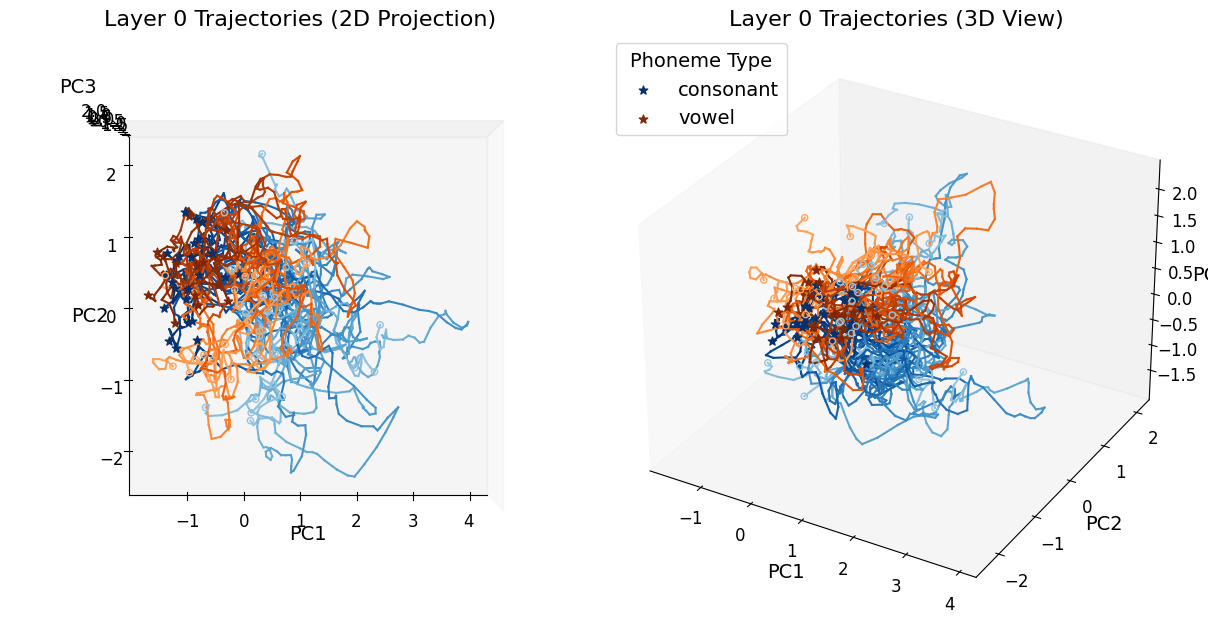

consonant
vowel


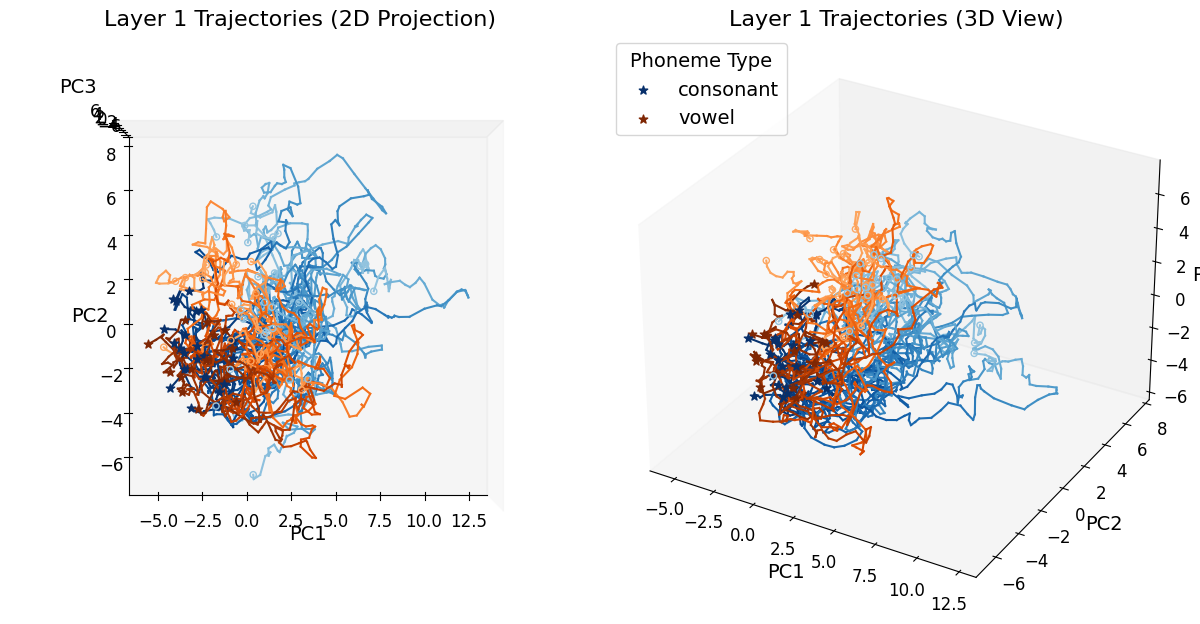

consonant
vowel


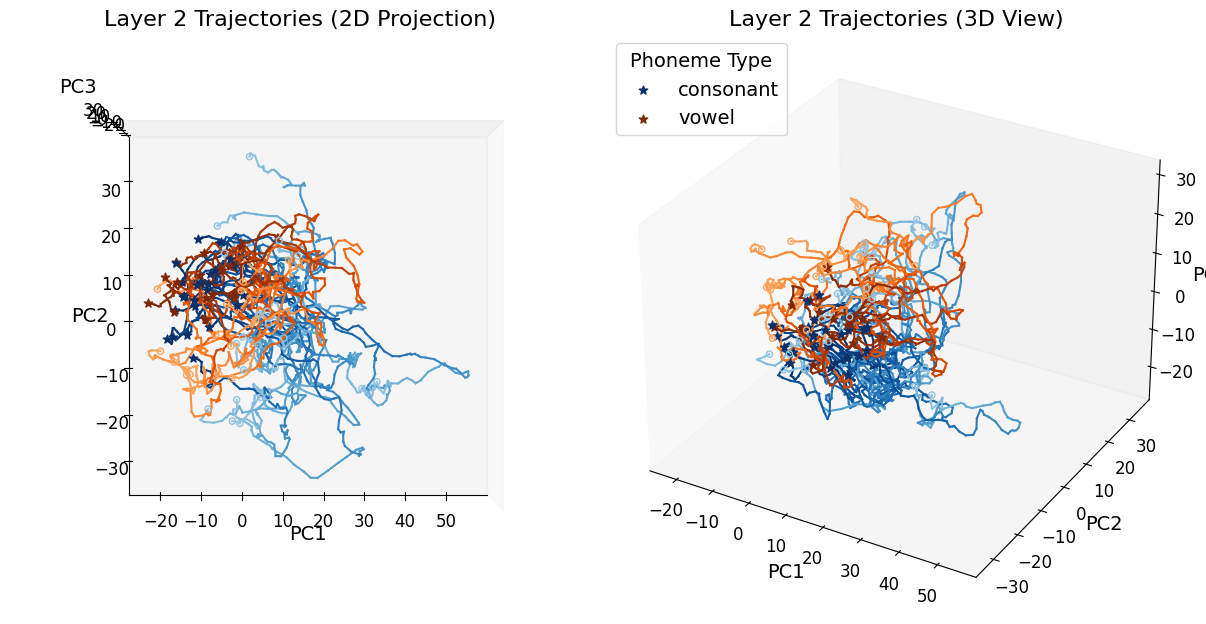

consonant
vowel


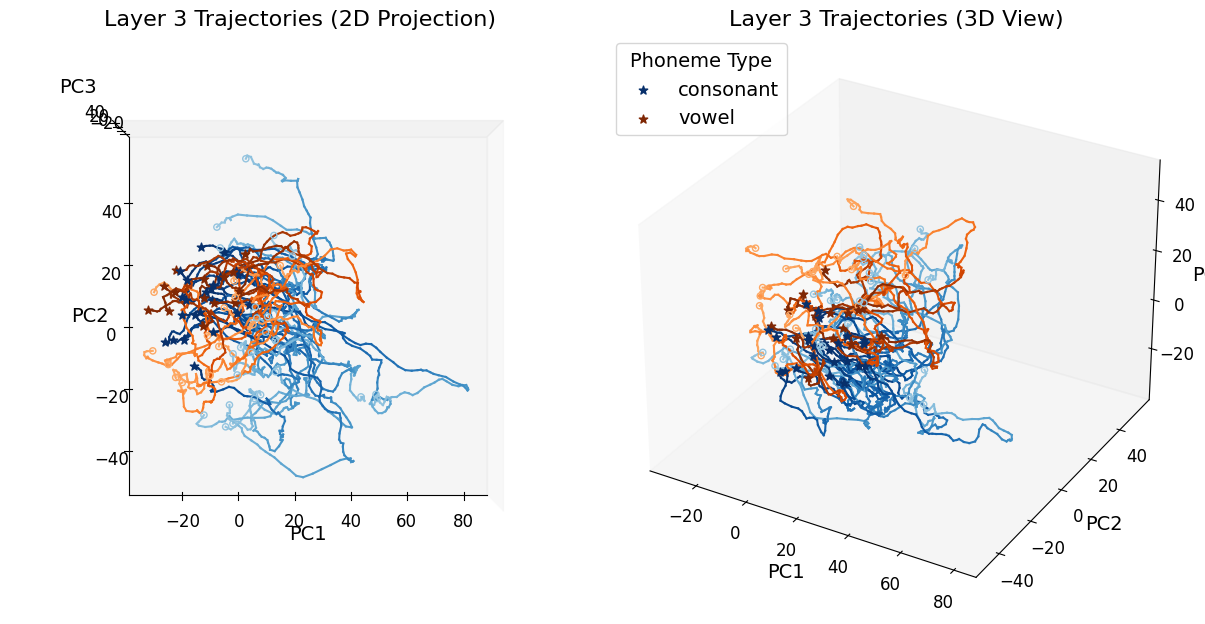

In [65]:
#### IPA Management 

what2plot = 'cueTime'
what2plot = 'goTime'

phonemeSubset2View = "cue_to_consoVowel"
whatFeature2use = "cue_to_consoVowelSil"
seqColorMaps = ['Blues_r','Oranges_r']

PCApandasIPA_clusterNeighbors = PCApandasIPA.loc[(PCApandasIPA['cue_to_consoVowelSil'] == 'vowel')|(PCApandasIPA['cue_to_consoVowelSil'] == 'consonant')]
trial_types_Mask2color     = PCApandasIPA_clusterNeighbors[whatFeature2use] 
phoneColorGroups2use = sorted(list(set(trial_types_Mask2color)))
phoneColorGroups2use_dict = dict(zip(phoneColorGroups2use, np.arange(len(phoneColorGroups2use))))
print(phoneColorGroups2use_dict)

#@NICOLE, THIS TOGGLES BETWEEN PREP MOTOR PERIOD AND MOTOR EXECUTION PERIOD 
if what2plot == 'cueTime':
    sampleSubset2PlotArray = np.arange(0,85)
elif what2plot == 'goTime':
    sampleSubset2PlotArray = np.arange(85,160)

flatten_3D = False  # False = free 3D, True = fixed 2D-like view

# LAYERS OF SSM
for layIdx in range(numLayers):
    fig = plt.figure(figsize=[12, 6])
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # Left plot (fake 2D by view angle)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Right plot (normal 3D)
    axs = [ax1, ax2]

    LegendStr =[]
    hhAll = []
    PC_act_layer = pca_results[layIdx]['pcs_unraveled']
    PCs_MeanAct = np.mean(PC_act_layer, axis=1)
    # print('PCs_MeanAct')
    # print(np.shape(PCs_MeanAct))
    
    phonemeCentroids_phoneUsed =  []
    counterI = 0
    # NICOLE CONSONANTS VS VOWEL COLOR 
    for mask2use, colorBankIdx in phoneColorGroups2use_dict.items(): 
        
        print(mask2use)
        trial_types_subSetCentroid = PCApandasIPA_clusterNeighbors.loc[((PCApandasIPA_clusterNeighbors[whatFeature2use] == mask2use))]
        # display(trial_types_subSetCentroid)
        
        for ignoreThisIdx, phoneID in enumerate(trial_types_subSetCentroid.phoneme):
            phoneIdx2use = tickLabels.index(phoneID)

                    
            # Define the range of the colormap to use (e.g., from 0.2 to 1.0 to avoid the lightest colors)
            cmap_rawColor = plt.get_cmap(seqColorMaps[colorBankIdx])
            color_sample = cmap_rawColor(0.5)
            cmap = LinearSegmentedColormap.from_list('cmapSegmented', cmap_rawColor(np.linspace(0.6, 0, len(sampleSubset2PlotArray))))  # Take the range from 0.2 to 1.0
            normForcmap = plt.Normalize(vmin=0, vmax=len(sampleSubset2PlotArray)-1)


            # Smooth across time (last dim), e.g., sigma=2 for mild smoothing
            smoothedPC_1 = gaussian_filter1d(np.squeeze(PCs_MeanAct[phoneIdx2use][1][sampleSubset2PlotArray]), sigma=sigma)
            smoothedPC_2 = gaussian_filter1d(np.squeeze(PCs_MeanAct[phoneIdx2use][2][sampleSubset2PlotArray]), sigma=sigma)
            smoothedPC_3 = gaussian_filter1d(np.squeeze(PCs_MeanAct[phoneIdx2use][3][sampleSubset2PlotArray]), sigma=sigma)


            
             # Plot trajectory lines on both axes
            # @NICOLE - THIS IS THE TIME VARIABLE 
            for i in range(len(smoothedPC_1) - 1):
                for ax in [ax1, ax2]:
                    ax.plot([smoothedPC_1[i], smoothedPC_1[i + 1]],
                            [smoothedPC_2[i], smoothedPC_2[i + 1]],
                            [smoothedPC_3[i], smoothedPC_3[i + 1]],
                            color=cmap(normForcmap(i)))

            
            for ax in [ax1, ax2]:
                # Plot start point 'o' on both axes
                ax.scatter(smoothedPC_1[0],
                           smoothedPC_2[0],
                           smoothedPC_3[0],
                           facecolors='none', edgecolors=cmap(0), marker='o', s=20)

                # Plot end point '*' on both axes
                hh = ax.scatter(smoothedPC_1[-1],
                           smoothedPC_2[-1],
                           smoothedPC_3[-1],
                           color=cmap(1.0), marker='*', s=40)

                if ax == ax1:
                    if (colorBankIdx == 0) & (ignoreThisIdx == 0):
                        LegendStr.append(mask2use)
                        hhAll.append(hh)
                    elif (colorBankIdx == 1) & (ignoreThisIdx == 0):
                        LegendStr.append(mask2use)
                        hhAll.append(hh)
                        ax2.legend(hhAll, LegendStr, loc='upper left', title='Phoneme Type', fontsize=14, title_fontsize=14)

                        

        
    # Set labels, titles, and formatting for both axes
    for ax in [ax1, ax2]:
        ax.set_xlabel('PC1', fontsize=14)
        ax.set_ylabel('PC2', fontsize=14)
        ax.set_zlabel('PC3', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(False)
        
    

    ax1.set_title(f"Layer {layIdx} Trajectories (2D Projection)", fontsize=16)
    ax2.set_title(f"Layer {layIdx} Trajectories (3D View)", fontsize=16)

    # Set viewing angles
    ax1.view_init(elev=90, azim=-90)   # Flattened view to look like 2D (top-down)
    ax2.view_init(elev=30, azim=-60)   # Normal 3D perspective

    plt.tight_layout()
    plt.show()
              


In [ ]:
break

# Training Notes 

#### Compare 128 Raw Data

In [ ]:
# Base model: 
# Elapsed time: 91.4808 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.65625 (SD = 0.040019523)

# 6 layers instead of 4, put layers back to 4
# Elapsed time: 150.0504 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.64125 (SD = 0.0410982)

# d_model   = len(CHs2use)*2, # len(CHs2use) / len(CHs2use)*2 / len(CHs2use)*4
# Elapsed time: 178.6587 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.65250003 (SD = 0.04023368)

# d_model   = len(CHs2use)*4, # len(CHs2use) / len(CHs2use)*2 / len(CHs2use)*4 => left d_model at ch*4
# Elapsed time: 276.6025 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.51125 (SD = 0.2523917)


# PEAK_LR     = 1e-3   # baseline is 5e-3, also trying 3e-3,1e-3
# Elapsed time: 190.0311 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.43625003 (SD = 0.27337304)


# PEAK_LR     = 3e-3 
# Elapsed time: 200.1858 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.675 (SD = 0.05505678)

#### Grid Search Idea 
# 1. d_model     → try 128, 256*, 512
# 2. learning rate → try 1e-3, 3e-3*, 5e-3
# 3. n_layers    → try 2, 4*, 6
# 4. dropout     → 0.3, 0.5
# dropout: float = 0.3
# Elapsed time: 189.4431 seconds
# %%%%%% SSM DATA = rawData , INPUT CHs = 128
# Mean Test Acc = 0.65625006 (SD = 0.065490924)




#### Compare 128 vs 60 Raw PCs

In [ ]:
# === Fold 1 ===
# epoch 05  lr 5.22e-04  train-acc 0.031  val-acc 0.062  time 4.3s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.328  val-acc 0.350  time 6.0s  best 0.350
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.750  time 7.7s  best 0.750
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.675  time 9.4s  best 0.750
# Early stop at epoch 25 – best val_acc=0.750
# Fold 1 test accuracy: 0.650

# === Fold 2 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.025  time 1.8s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.047  val-acc 0.150  time 3.5s  best 0.150
# epoch 15  lr 2.60e-03  train-acc 0.922  val-acc 0.675  time 5.3s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.637  time 7.0s  best 0.688
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.650  time 8.7s  best 0.688
# Early stop at epoch 29 – best val_acc=0.688
# Fold 2 test accuracy: 0.688

# === Fold 3 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.100  time 1.7s  best 0.100
# epoch 10  lr 1.40e-03  train-acc 0.406  val-acc 0.412  time 3.4s  best 0.412
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.650  time 5.1s  best 0.650
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.663  time 6.8s  best 0.675
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.688  time 8.5s  best 0.688
# epoch 30  lr 5.00e-03  train-acc 0.984  val-acc 0.650  time 10.1s  best 0.700
# epoch 35  lr 4.94e-03  train-acc 1.000  val-acc 0.588  time 11.8s  best 0.700
# Early stop at epoch 37 – best val_acc=0.700
# Fold 3 test accuracy: 0.625

# === Fold 4 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.013  time 1.7s  best 0.025
# epoch 10  lr 1.40e-03  train-acc 0.391  val-acc 0.325  time 3.4s  best 0.325
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.663  time 5.1s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.650  time 6.8s  best 0.725
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.663  time 8.5s  best 0.725
# Early stop at epoch 28 – best val_acc=0.725
# Fold 4 test accuracy: 0.663

# === Fold 5 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.050  time 1.7s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.219  val-acc 0.300  time 3.4s  best 0.300
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.663  time 5.1s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.713  time 6.8s  best 0.713
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.637  time 8.5s  best 0.713
# Early stop at epoch 30 – best val_acc=0.713
# Fold 5 test accuracy: 0.600

# === Fold 6 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.087  time 1.7s  best 0.087
# epoch 10  lr 1.40e-03  train-acc 0.219  val-acc 0.275  time 3.4s  best 0.275
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.663  time 5.0s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.637  time 6.7s  best 0.688
# Early stop at epoch 24 – best val_acc=0.688
# Fold 6 test accuracy: 0.738

# === Fold 7 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.050  time 1.7s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.406  val-acc 0.438  time 3.3s  best 0.438
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.650  time 5.0s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.725  time 6.6s  best 0.725
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.700  time 8.3s  best 0.725
# Early stop at epoch 30 – best val_acc=0.725
# Fold 7 test accuracy: 0.600

# === Fold 8 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.038  time 1.6s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.359  val-acc 0.375  time 3.3s  best 0.375
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.675  time 5.0s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.688  time 6.7s  best 0.688
# epoch 25  lr 4.68e-03  train-acc 0.953  val-acc 0.588  time 8.4s  best 0.688
# Early stop at epoch 29 – best val_acc=0.688
# Fold 8 test accuracy: 0.637

# === Fold 9 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.025  time 1.7s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.406  val-acc 0.375  time 3.4s  best 0.375
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.637  time 5.2s  best 0.650
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.625  time 6.9s  best 0.650
# Early stop at epoch 23 – best val_acc=0.650
# Fold 9 test accuracy: 0.613

# === Fold 10 ===
# epoch 05  lr 5.22e-04  train-acc 0.000  val-acc 0.025  time 1.7s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.516  val-acc 0.412  time 3.3s  best 0.412
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.600  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.538  time 6.6s  best 0.700
# Early stop at epoch 22 – best val_acc=0.700
# Fold 10 test accuracy: 0.562
# Elapsed time: 98.0426 seconds
# %%%%%% SSM DATA, INPUT CHs = rawPCs 128
# Mean Test Acc = 0.6375 (SD = 0.047434166)

In [ ]:
# === Fold 1 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.062  time 4.2s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.234  val-acc 0.250  time 5.8s  best 0.250
# epoch 15  lr 2.60e-03  train-acc 0.906  val-acc 0.600  time 7.5s  best 0.600
# epoch 20  lr 3.80e-03  train-acc 0.922  val-acc 0.538  time 9.2s  best 0.600
# epoch 25  lr 4.68e-03  train-acc 0.938  val-acc 0.550  time 10.9s  best 0.650
# epoch 30  lr 5.00e-03  train-acc 0.953  val-acc 0.550  time 12.6s  best 0.650
# Early stop at epoch 31 – best val_acc=0.650
# Fold 1 test accuracy: 0.675

# === Fold 2 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.000  time 1.6s  best 0.025
# epoch 10  lr 1.40e-03  train-acc 0.125  val-acc 0.175  time 3.2s  best 0.175
# epoch 15  lr 2.60e-03  train-acc 0.891  val-acc 0.663  time 4.7s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.600  time 6.3s  best 0.663
# Early stop at epoch 25 – best val_acc=0.663
# Fold 2 test accuracy: 0.575

# === Fold 3 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.000  time 1.6s  best 0.013
# epoch 10  lr 1.40e-03  train-acc 0.188  val-acc 0.312  time 3.2s  best 0.312
# epoch 15  lr 2.60e-03  train-acc 0.906  val-acc 0.613  time 4.8s  best 0.613
# epoch 20  lr 3.80e-03  train-acc 0.906  val-acc 0.550  time 6.5s  best 0.613
# Early stop at epoch 25 – best val_acc=0.613
# Fold 3 test accuracy: 0.613

# === Fold 4 ===
# epoch 05  lr 5.22e-04  train-acc 0.031  val-acc 0.062  time 1.7s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.344  val-acc 0.312  time 3.3s  best 0.312
# epoch 15  lr 2.60e-03  train-acc 0.891  val-acc 0.625  time 4.9s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 0.922  val-acc 0.575  time 6.5s  best 0.675
# Early stop at epoch 23 – best val_acc=0.675
# Fold 4 test accuracy: 0.613

# === Fold 5 ===
# epoch 05  lr 5.22e-04  train-acc 0.094  val-acc 0.025  time 1.6s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.203  val-acc 0.263  time 3.2s  best 0.263
# epoch 15  lr 2.60e-03  train-acc 0.906  val-acc 0.675  time 4.8s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.637  time 6.4s  best 0.675
# Early stop at epoch 25 – best val_acc=0.675
# Fold 5 test accuracy: 0.550

# === Fold 6 ===
# epoch 05  lr 5.22e-04  train-acc 0.031  val-acc 0.038  time 1.6s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.188  val-acc 0.200  time 3.1s  best 0.200
# epoch 15  lr 2.60e-03  train-acc 0.875  val-acc 0.625  time 4.7s  best 0.625
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.575  time 6.3s  best 0.625
# Early stop at epoch 25 – best val_acc=0.625
# Fold 6 test accuracy: 0.663

# === Fold 7 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.025  time 1.6s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.297  val-acc 0.400  time 3.2s  best 0.400
# epoch 15  lr 2.60e-03  train-acc 0.891  val-acc 0.600  time 4.8s  best 0.600
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.613  time 6.4s  best 0.663
# epoch 25  lr 4.68e-03  train-acc 0.922  val-acc 0.600  time 8.1s  best 0.663
# Early stop at epoch 27 – best val_acc=0.663
# Fold 7 test accuracy: 0.512

# === Fold 8 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.050  time 1.6s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.438  val-acc 0.338  time 3.3s  best 0.338
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.512  time 4.9s  best 0.588
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.575  time 6.5s  best 0.588
# Early stop at epoch 23 – best val_acc=0.588
# Fold 8 test accuracy: 0.588

# === Fold 9 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.050  time 1.6s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.484  val-acc 0.388  time 3.2s  best 0.388
# epoch 15  lr 2.60e-03  train-acc 0.906  val-acc 0.525  time 4.8s  best 0.550
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.512  time 6.3s  best 0.600
# epoch 25  lr 4.68e-03  train-acc 0.922  val-acc 0.475  time 7.9s  best 0.600
# Early stop at epoch 27 – best val_acc=0.600
# Fold 9 test accuracy: 0.538

# === Fold 10 ===
# epoch 05  lr 5.22e-04  train-acc 0.031  val-acc 0.025  time 1.6s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.391  val-acc 0.300  time 3.2s  best 0.300
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.588  time 4.8s  best 0.613
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.575  time 6.3s  best 0.625
# epoch 25  lr 4.68e-03  train-acc 0.984  val-acc 0.562  time 8.0s  best 0.625
# Early stop at epoch 27 – best val_acc=0.625
# Fold 10 test accuracy: 0.575
# Elapsed time: 87.5373 seconds
# %%%%%% SSM DATA, INPUT CHs = rawPCs 60
# Mean Test Acc = 0.59 (SD = 0.049307715)

#### Compare Diff SmoothingVal of 128 PCs

In [ ]:
# === Fold 1 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.113  time 4.2s  best 0.113
# epoch 10  lr 1.40e-03  train-acc 0.578  val-acc 0.575  time 5.8s  best 0.575
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.625  time 7.4s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.637  time 9.1s  best 0.700
# Early stop at epoch 22 – best val_acc=0.700
# Fold 1 test accuracy: 0.650

# === Fold 2 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.075  time 1.7s  best 0.075
# epoch 10  lr 1.40e-03  train-acc 0.438  val-acc 0.475  time 3.4s  best 0.475
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.637  time 5.1s  best 0.725
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.713  time 6.7s  best 0.725
# Early stop at epoch 24 – best val_acc=0.725
# Fold 2 test accuracy: 0.663

# === Fold 3 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.175  time 1.7s  best 0.175
# epoch 10  lr 1.40e-03  train-acc 0.672  val-acc 0.538  time 3.3s  best 0.538
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.637  time 5.0s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.650  time 6.7s  best 0.688
# epoch 25  lr 4.68e-03  train-acc 0.984  val-acc 0.725  time 8.4s  best 0.725
# epoch 30  lr 5.00e-03  train-acc 0.969  val-acc 0.700  time 10.1s  best 0.725
# Early stop at epoch 35 – best val_acc=0.725
# Fold 3 test accuracy: 0.588

# === Fold 4 ===
# epoch 05  lr 5.22e-04  train-acc 0.094  val-acc 0.050  time 1.7s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.844  val-acc 0.562  time 3.3s  best 0.562
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.625  time 5.0s  best 0.650
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.663  time 6.7s  best 0.700
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.650  time 8.3s  best 0.700
# Early stop at epoch 29 – best val_acc=0.700
# Fold 4 test accuracy: 0.725

# === Fold 5 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.075  time 1.7s  best 0.075
# epoch 10  lr 1.40e-03  train-acc 0.594  val-acc 0.613  time 3.3s  best 0.613
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.675  time 5.0s  best 0.713
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.637  time 6.7s  best 0.713
# Early stop at epoch 23 – best val_acc=0.713
# Fold 5 test accuracy: 0.600

# === Fold 6 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.188  time 1.7s  best 0.188
# epoch 10  lr 1.40e-03  train-acc 0.734  val-acc 0.550  time 3.3s  best 0.550
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.688  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.675  time 6.7s  best 0.713
# epoch 25  lr 4.68e-03  train-acc 0.906  val-acc 0.675  time 8.3s  best 0.713
# Early stop at epoch 26 – best val_acc=0.713
# Fold 6 test accuracy: 0.650

# === Fold 7 ===
# epoch 05  lr 5.22e-04  train-acc 0.156  val-acc 0.175  time 1.7s  best 0.175
# epoch 10  lr 1.40e-03  train-acc 0.594  val-acc 0.538  time 3.4s  best 0.538
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.663  time 5.0s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.738  time 6.7s  best 0.738
# epoch 25  lr 4.68e-03  train-acc 0.938  val-acc 0.650  time 8.4s  best 0.738
# Early stop at epoch 30 – best val_acc=0.738
# Fold 7 test accuracy: 0.575

# === Fold 8 ===
# epoch 05  lr 5.22e-04  train-acc 0.109  val-acc 0.163  time 1.7s  best 0.163
# epoch 10  lr 1.40e-03  train-acc 0.812  val-acc 0.600  time 3.4s  best 0.600
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.663  time 5.1s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.575  time 6.8s  best 0.663
# Early stop at epoch 23 – best val_acc=0.663
# Fold 8 test accuracy: 0.700

# === Fold 9 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.050  time 1.7s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.578  val-acc 0.475  time 3.3s  best 0.475
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.588  time 5.0s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.613  time 6.7s  best 0.663
# Early stop at epoch 24 – best val_acc=0.663
# Fold 9 test accuracy: 0.625

# === Fold 10 ===
# epoch 05  lr 5.22e-04  train-acc 0.109  val-acc 0.113  time 1.7s  best 0.113
# epoch 10  lr 1.40e-03  train-acc 0.766  val-acc 0.588  time 3.3s  best 0.588
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.613  time 5.0s  best 0.713
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.637  time 6.7s  best 0.713
# Early stop at epoch 22 – best val_acc=0.713
# Fold 10 test accuracy: 0.625
# Elapsed time: 90.4617 seconds
# %%%%%% SSM DATA = SmoothedPCs , SmoothingVal = 10 , INPUT CHs = 128
# Mean Test Acc = 0.64 (SD = 0.045345895)

In [ ]:
# === Fold 1 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.113  time 4.2s  best 0.113
# epoch 10  lr 1.40e-03  train-acc 0.562  val-acc 0.575  time 5.8s  best 0.575
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.675  time 7.5s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.637  time 9.2s  best 0.738
# epoch 25  lr 4.68e-03  train-acc 0.984  val-acc 0.725  time 10.8s  best 0.738
# Early stop at epoch 28 – best val_acc=0.738
# Fold 1 test accuracy: 0.688

# === Fold 2 ===
# epoch 05  lr 5.22e-04  train-acc 0.031  val-acc 0.050  time 1.6s  best 0.050
# epoch 10  lr 1.40e-03  train-acc 0.406  val-acc 0.438  time 3.3s  best 0.438
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.637  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.713  time 6.8s  best 0.713
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.625  time 8.5s  best 0.713
# Early stop at epoch 30 – best val_acc=0.713
# Fold 2 test accuracy: 0.688

# === Fold 3 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.188  time 1.7s  best 0.188
# epoch 10  lr 1.40e-03  train-acc 0.672  val-acc 0.538  time 3.4s  best 0.538
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.637  time 5.1s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.700  time 6.7s  best 0.700
# epoch 25  lr 4.68e-03  train-acc 1.000  val-acc 0.663  time 8.5s  best 0.700
# Early stop at epoch 30 – best val_acc=0.700
# Fold 3 test accuracy: 0.637

# === Fold 4 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.038  time 1.7s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.797  val-acc 0.550  time 3.4s  best 0.550
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.663  time 5.0s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.650  time 6.7s  best 0.688
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.700  time 8.4s  best 0.700
# epoch 30  lr 5.00e-03  train-acc 0.984  val-acc 0.613  time 10.0s  best 0.700
# Early stop at epoch 35 – best val_acc=0.700
# Fold 4 test accuracy: 0.688

# === Fold 5 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.062  time 1.7s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.578  val-acc 0.600  time 3.3s  best 0.600
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.688  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.613  time 6.7s  best 0.700
# Early stop at epoch 23 – best val_acc=0.700
# Fold 5 test accuracy: 0.625

# === Fold 6 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.175  time 1.7s  best 0.175
# epoch 10  lr 1.40e-03  train-acc 0.719  val-acc 0.550  time 3.3s  best 0.550
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.700  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.953  val-acc 0.575  time 6.7s  best 0.762
# epoch 25  lr 4.68e-03  train-acc 1.000  val-acc 0.700  time 8.3s  best 0.762
# Early stop at epoch 26 – best val_acc=0.762
# Fold 6 test accuracy: 0.600

# === Fold 7 ===
# epoch 05  lr 5.22e-04  train-acc 0.125  val-acc 0.163  time 1.6s  best 0.163
# epoch 10  lr 1.40e-03  train-acc 0.594  val-acc 0.512  time 3.3s  best 0.512
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.700  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.700  time 6.6s  best 0.750
# epoch 25  lr 4.68e-03  train-acc 0.938  val-acc 0.675  time 8.3s  best 0.750
# Early stop at epoch 28 – best val_acc=0.750
# Fold 7 test accuracy: 0.613

# === Fold 8 ===
# epoch 05  lr 5.22e-04  train-acc 0.125  val-acc 0.138  time 1.7s  best 0.138
# epoch 10  lr 1.40e-03  train-acc 0.812  val-acc 0.613  time 3.4s  best 0.613
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.650  time 5.1s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.613  time 6.8s  best 0.663
# Early stop at epoch 24 – best val_acc=0.663
# Fold 8 test accuracy: 0.688

# === Fold 9 ===
# epoch 05  lr 5.22e-04  train-acc 0.016  val-acc 0.025  time 1.7s  best 0.025
# epoch 10  lr 1.40e-03  train-acc 0.547  val-acc 0.450  time 3.4s  best 0.450
# epoch 15  lr 2.60e-03  train-acc 0.953  val-acc 0.600  time 5.1s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.625  time 6.8s  best 0.663
# Early stop at epoch 24 – best val_acc=0.663
# Fold 9 test accuracy: 0.625

# === Fold 10 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.125  time 1.7s  best 0.125
# epoch 10  lr 1.40e-03  train-acc 0.766  val-acc 0.588  time 3.4s  best 0.588
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.637  time 5.1s  best 0.713
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.562  time 6.7s  best 0.713
# Early stop at epoch 22 – best val_acc=0.713
# Fold 10 test accuracy: 0.613
# Elapsed time: 95.0390 seconds
# %%%%%% SSM DATA = SmoothedPCs , SmoothingVal = 5 , INPUT CHs = 128
# Mean Test Acc = 0.64625007 (SD = 0.034932967)

In [ ]:
# === Fold 1 ===
# epoch 05  lr 5.22e-04  train-acc 0.047  val-acc 0.087  time 4.2s  best 0.087
# epoch 10  lr 1.40e-03  train-acc 0.531  val-acc 0.600  time 5.8s  best 0.600
# epoch 15  lr 2.60e-03  train-acc 0.938  val-acc 0.663  time 7.5s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.922  val-acc 0.675  time 9.1s  best 0.700
# Early stop at epoch 22 – best val_acc=0.700
# Fold 1 test accuracy: 0.675

# === Fold 2 ===
# epoch 05  lr 5.22e-04  train-acc 0.000  val-acc 0.062  time 1.7s  best 0.062
# epoch 10  lr 1.40e-03  train-acc 0.344  val-acc 0.363  time 3.3s  best 0.363
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.688  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.637  time 6.7s  best 0.738
# epoch 25  lr 4.68e-03  train-acc 0.938  val-acc 0.613  time 8.4s  best 0.738
# Early stop at epoch 26 – best val_acc=0.738
# Fold 2 test accuracy: 0.625

# === Fold 3 ===
# epoch 05  lr 5.22e-04  train-acc 0.094  val-acc 0.163  time 1.7s  best 0.163
# epoch 10  lr 1.40e-03  train-acc 0.594  val-acc 0.550  time 3.4s  best 0.550
# epoch 15  lr 2.60e-03  train-acc 1.000  val-acc 0.688  time 5.1s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.700  time 6.7s  best 0.738
# epoch 25  lr 4.68e-03  train-acc 0.984  val-acc 0.637  time 8.4s  best 0.738
# Early stop at epoch 27 – best val_acc=0.738
# Fold 3 test accuracy: 0.588

# === Fold 4 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.038  time 1.7s  best 0.038
# epoch 10  lr 1.40e-03  train-acc 0.688  val-acc 0.525  time 3.3s  best 0.525
# epoch 15  lr 2.60e-03  train-acc 0.938  val-acc 0.663  time 5.0s  best 0.675
# epoch 20  lr 3.80e-03  train-acc 0.938  val-acc 0.650  time 6.6s  best 0.675
# Early stop at epoch 24 – best val_acc=0.675
# Fold 4 test accuracy: 0.675

# === Fold 5 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.038  time 1.7s  best 0.075
# epoch 10  lr 1.40e-03  train-acc 0.500  val-acc 0.575  time 3.3s  best 0.575
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.675  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.713  time 6.7s  best 0.725
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.613  time 8.3s  best 0.725
# epoch 30  lr 5.00e-03  train-acc 0.969  val-acc 0.738  time 10.0s  best 0.738
# epoch 35  lr 4.94e-03  train-acc 0.984  val-acc 0.675  time 11.7s  best 0.738
# Early stop at epoch 39 – best val_acc=0.738
# Fold 5 test accuracy: 0.550

# === Fold 6 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.163  time 1.7s  best 0.163
# epoch 10  lr 1.40e-03  train-acc 0.672  val-acc 0.550  time 3.3s  best 0.550
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.675  time 5.0s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 0.969  val-acc 0.675  time 6.7s  best 0.688
# Early stop at epoch 22 – best val_acc=0.688
# Fold 6 test accuracy: 0.663

# === Fold 7 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.113  time 1.7s  best 0.113
# epoch 10  lr 1.40e-03  train-acc 0.625  val-acc 0.512  time 3.4s  best 0.512
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.688  time 5.0s  best 0.700
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.675  time 6.7s  best 0.725
# epoch 25  lr 4.68e-03  train-acc 0.969  val-acc 0.700  time 8.4s  best 0.725
# epoch 30  lr 5.00e-03  train-acc 0.984  val-acc 0.738  time 10.0s  best 0.788
# epoch 35  lr 4.94e-03  train-acc 0.984  val-acc 0.762  time 11.8s  best 0.788
# Early stop at epoch 38 – best val_acc=0.788
# Fold 7 test accuracy: 0.600

# === Fold 8 ===
# epoch 05  lr 5.22e-04  train-acc 0.125  val-acc 0.100  time 1.6s  best 0.100
# epoch 10  lr 1.40e-03  train-acc 0.703  val-acc 0.575  time 3.3s  best 0.575
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.650  time 5.0s  best 0.663
# epoch 20  lr 3.80e-03  train-acc 0.984  val-acc 0.613  time 6.6s  best 0.688
# epoch 25  lr 4.68e-03  train-acc 0.953  val-acc 0.663  time 8.3s  best 0.700
# epoch 30  lr 5.00e-03  train-acc 1.000  val-acc 0.625  time 10.0s  best 0.700
# Early stop at epoch 31 – best val_acc=0.700
# Fold 8 test accuracy: 0.650

# === Fold 9 ===
# epoch 05  lr 5.22e-04  train-acc 0.062  val-acc 0.025  time 1.7s  best 0.025
# epoch 10  lr 1.40e-03  train-acc 0.531  val-acc 0.400  time 3.4s  best 0.400
# epoch 15  lr 2.60e-03  train-acc 0.969  val-acc 0.613  time 5.1s  best 0.637
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.675  time 6.8s  best 0.675
# epoch 25  lr 4.68e-03  train-acc 1.000  val-acc 0.650  time 8.4s  best 0.688
# epoch 30  lr 5.00e-03  train-acc 1.000  val-acc 0.675  time 10.1s  best 0.700
# epoch 35  lr 4.94e-03  train-acc 1.000  val-acc 0.675  time 11.8s  best 0.700
# Early stop at epoch 38 – best val_acc=0.700
# Fold 9 test accuracy: 0.613

# === Fold 10 ===
# epoch 05  lr 5.22e-04  train-acc 0.078  val-acc 0.100  time 1.7s  best 0.100
# epoch 10  lr 1.40e-03  train-acc 0.750  val-acc 0.562  time 3.4s  best 0.562
# epoch 15  lr 2.60e-03  train-acc 0.984  val-acc 0.650  time 5.1s  best 0.688
# epoch 20  lr 3.80e-03  train-acc 1.000  val-acc 0.600  time 6.7s  best 0.688
# Early stop at epoch 22 – best val_acc=0.688
# Fold 10 test accuracy: 0.588
# Elapsed time: 100.8914 seconds
# %%%%%% SSM DATA = SmoothedPCs , SmoothingVal = 1 , INPUT CHs = 128
# Mean Test Acc = 0.62250006 (SD = 0.04023369)